# Symulacja ciągów pseudolosowych, ich filtracja i analiza
1. Symulować szum biały o rozkładzie normlanym N(5, 0.1).
2. Na podstawie otrzymanego ciągu obliczyć gęstość prawdopodobieństwa, dystrybuantę, a też wartość oczekiwaną, wariancję i funkcję kowariancyjną.
3. Przeprowadzić filtrację danych z wykorzystaniem filtru dolnoprzepustowego FIR (SOJ) o różnych parametrach.
4. Obliczyć gęstość prawdopodobieństwa, dystrybuantę, a też wartość oczekiwaną, wariancję i funkcję kowariancyjną sygnału wyjściowego. Porównać wyniki z p 2.
Wyniki przedstawiać w postaci tablic oraz wykresów

# Literatura
1. Snopkowski R. Symulacja stochastyczna AGH, Kraków, 2007.
2. Niemiro W. Symulacje stochastyczne i metody Monte Carlo, Uniw. Warszawski, 2013.
3. Cacho K., Bily M., Bukowski J. Random processs, analysis and simulation, 1988
4. Othes R.K., Enochson Analiza numeryczna szeregów czasowych, WNT, Warszawa, 1988

-----------------------------------------

## Importowanie potrzebnych bibliotek

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, describe
from scipy import signal
import pandas  as pd
from IPython.display import display, Latex
from tabulate import tabulate

## 1. Symulacja szumu białego o rozkładzie normlanym N(5, 0.1).
### Wytworzenie szumu białego o rozkładzie Gassowskim

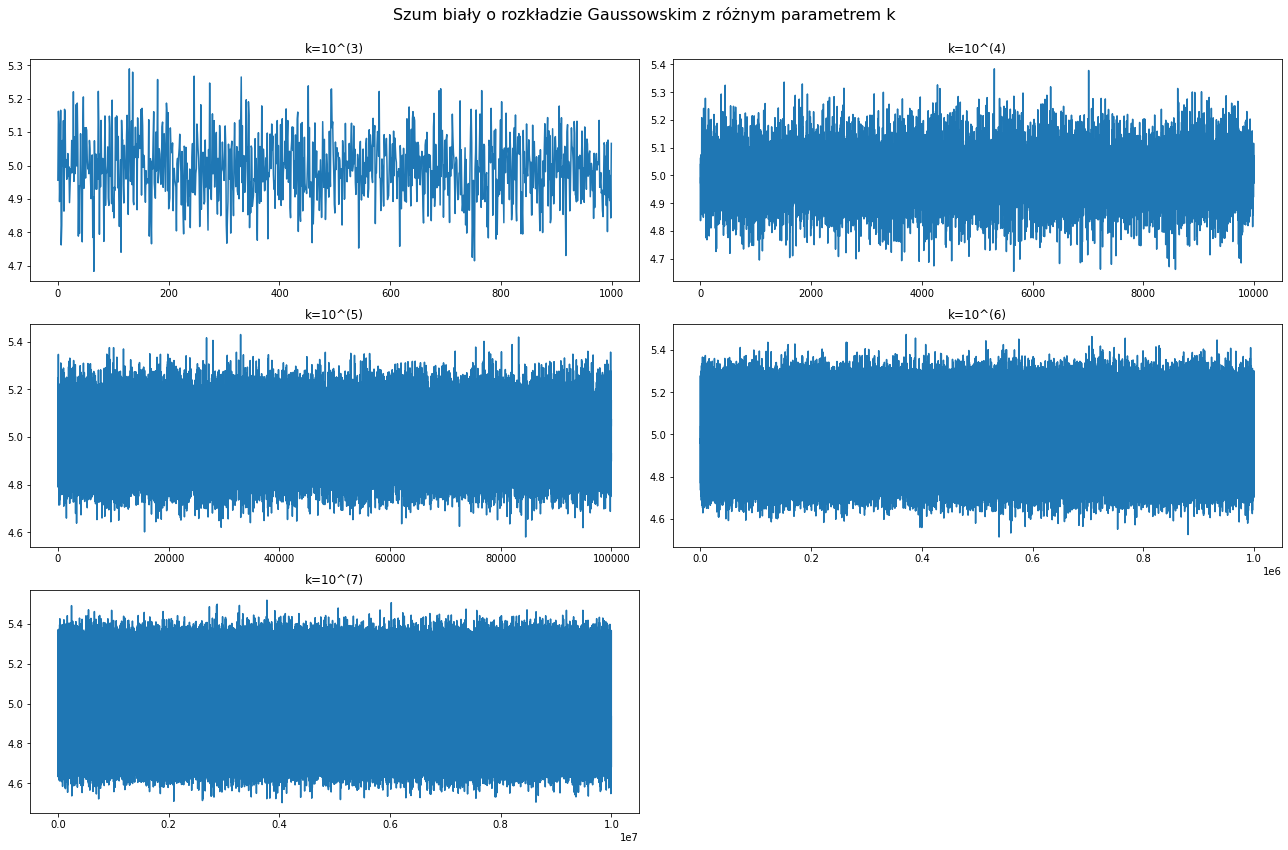

In [102]:
#Default parameters to describe white noise
mu = 5
sigma = 0.1
k_3 = pow(10,3)     #Amount of samples to generate white noise
k_4 = pow(10,4)
k_5 = pow(10,5)
k_6 = pow(10,6)
k_7 = pow(10,7)

samples_k_3 = np.random.normal(mu, sigma, size=k_3)
samples_k_4 = np.random.normal(mu, sigma, size=k_4)
samples_k_5 = np.random.normal(mu, sigma, size=k_5)
samples_k_6 = np.random.normal(mu, sigma, size=k_6)
samples_k_7 = np.random.normal(mu, sigma, size=k_7)

fig, axarr = plt.subplots(3, 2)
fig.set_figheight(12)
fig.set_figwidth(18)
fig.suptitle("Szum biały o rozkładzie Gaussowskim z różnym parametrem k", fontsize=16)

axarr[0, 0].plot(samples_k_3)
axarr[0, 0].set_title('k=10^(3)')
axarr[0, 1].plot(samples_k_4)
axarr[0, 1].set_title('k=10^(4)')
axarr[1, 0].plot(samples_k_5)
axarr[1, 0].set_title('k=10^(5)')
axarr[1, 1].plot(samples_k_6)
axarr[1, 1].set_title('k=10^(6)')
axarr[2, 0].plot(samples_k_7)
axarr[2, 0].set_title('k=10^(7)')
axarr[2, 1].set_visible(False)

# Tight layout often produces nice results
# but requires the title to be spaced accordingly
fig.tight_layout()
fig.subplots_adjust(top=0.92)

plt.show()

Powyższy wygenerowany diagram prezentuje szum biały składającego się z określonej liczby próbek zadeklarowanej w zmiennej <font color=yellow>samples_k{i}</font>. Szum biały jest rodzajem szumu akustycznego, który posiada całkowicie płaskie widmo. W procesie stochastycznym szum biały to ciąg nieskorelowanych zmiennych losowych o zerowej wartości oczekiwanej i stałej wariancji(czyli biały szum to proces kowariancyjnie stacjonarny) oraz w sensie ścisłym to biały szum w którym nieskorelowanie wzmianiamy do niezależności. Biały szum jest tak zwaną ,,cegiełką" podczas konstrukcji procesów stochastycznych. 

### Wyświetlenie histogramu szumu białego o charakterze Gaussowskim dla róznych k

In [103]:
def display_hist(samples, k):
    delta_x_1=1
    delta_x_2=0.6
    delta_x_3=0.3
    delta_x_4=0.1

    fig, axarr = plt.subplots(2, 2)
    fig.set_figheight(10)
    fig.set_figwidth(12)
    fig.suptitle("Histogram szumu białego z różną wartością Δx dla k={}".format(k), fontsize=16)

    axarr[0, 0].hist(samples, bins=int(6/delta_x_1))
    axarr[0, 0].set_title('Δx=1')
    axarr[0, 1].hist(samples, bins=int(6/delta_x_2))
    axarr[0, 1].set_title('Δx=0,6')
    axarr[1, 0].hist(samples, bins=int(6/delta_x_3))
    axarr[1, 0].set_title('Δx=0,3')
    axarr[1, 1].hist(samples, bins=int(6/delta_x_4))
    axarr[1, 1].set_title('Δx=0,1')

    # Tight layout often produces nice results
    # but requires the title to be spaced accordingly
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)

    plt.show()

#### k=10^(3)

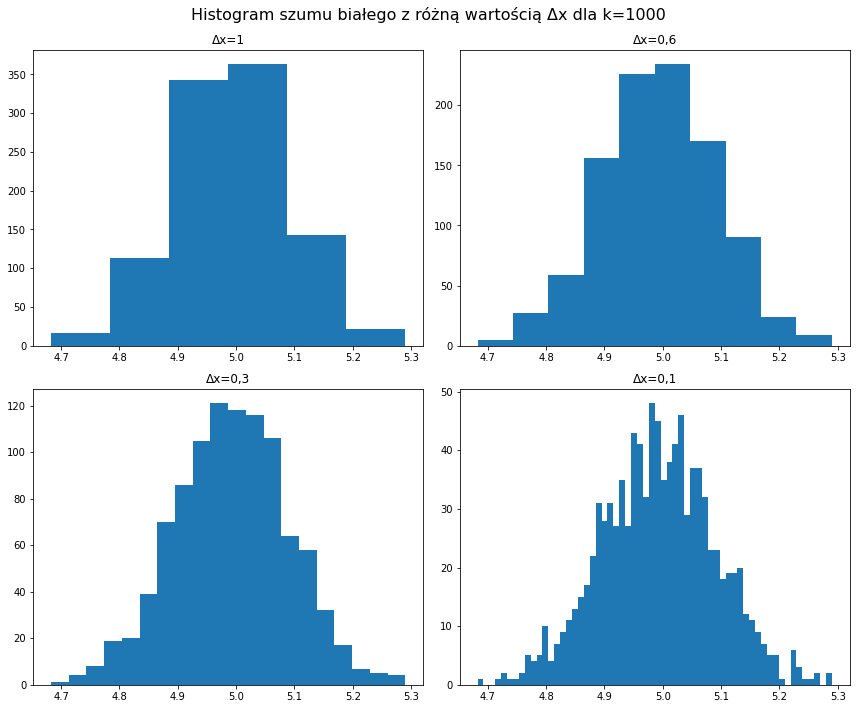

In [104]:
display_hist(samples_k_3, k_3)

#### k=10^(4)

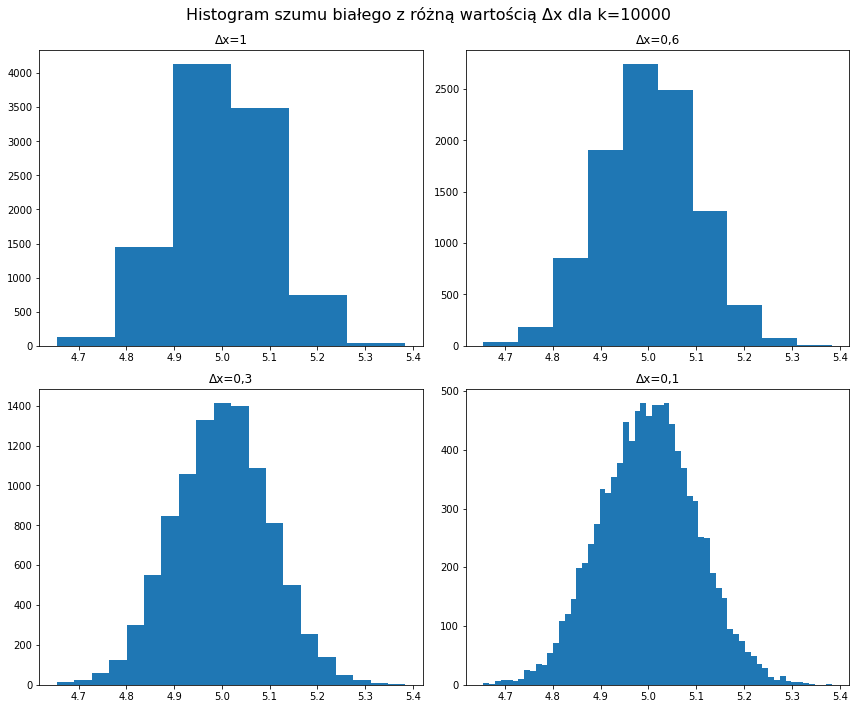

In [105]:
display_hist(samples_k_4, k_4)

#### k=10^(5)

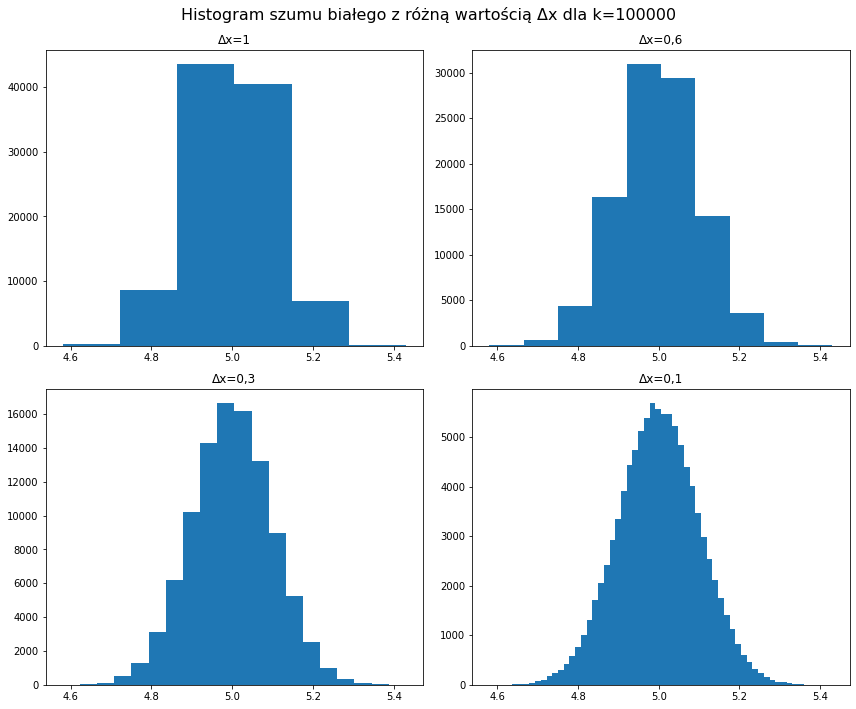

In [106]:
display_hist(samples_k_5, k_5)

####  k=10^(6)

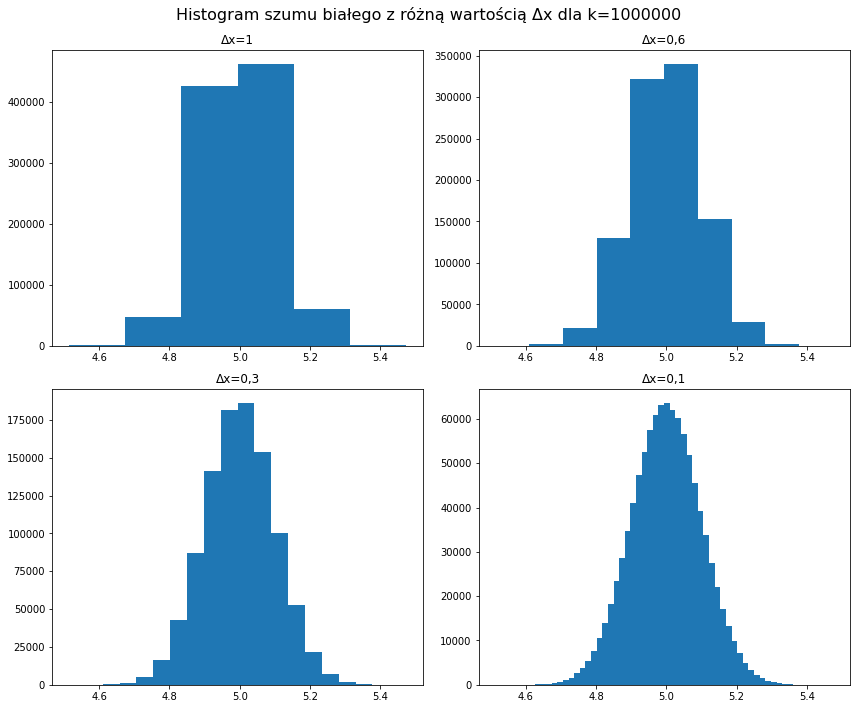

In [107]:
display_hist(samples_k_6, k_6)

#### k=10^(7)

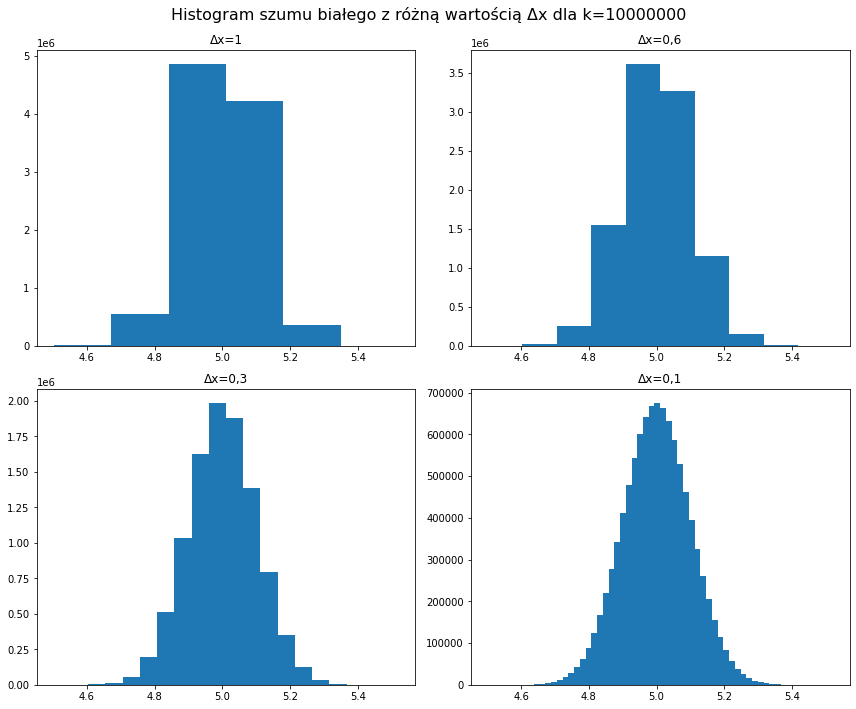

In [108]:
display_hist(samples_k_7, k_7)

## 2. Na podstawie otrzymanego ciągu obliczyć gęstość prawdopodobieństwta, dystrybuantę, a też wartość oczekiwan, wariancję i funkcję kowariancyjną.

### Obliczenie gęstości prawdopodobieństwa

<b>Gęstość prawdopodobieństwa</b> (ang. probability density function) to funkcja, która opisuje rozkład prawdopodobieństwa zmiennej losowej X. Gęstość prawdopodobieństwa może być używana do obliczenia prawdopodobieństwa wystąpienia wartości zmiennej losowej w określonym przedziale. W przeciwieństwie do dystrybuanty, gęstość prawdopodobieństwa nie jest równa prawdopodobieństwu, lecz określa szybkość zmian prawdopodobieństwa zmiennej losowej wokół danej wartości.

$$ f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}} $$

<font color=red>Uwaga aby wyświetlić gęstość prawdopodobieństwa należy posortować najpierw tablicę. Wytłumaczenie w linku poniżej</font>       
https://stackoverflow.com/questions/71296986/how-to-draw-the-probability-density-function-pdf-plot-in-python

In [109]:
def probability_pdf(samples):
    sort_samples = np.sort(samples)
    probability_pdf = norm.pdf(sort_samples, mu, sigma)
    return probability_pdf

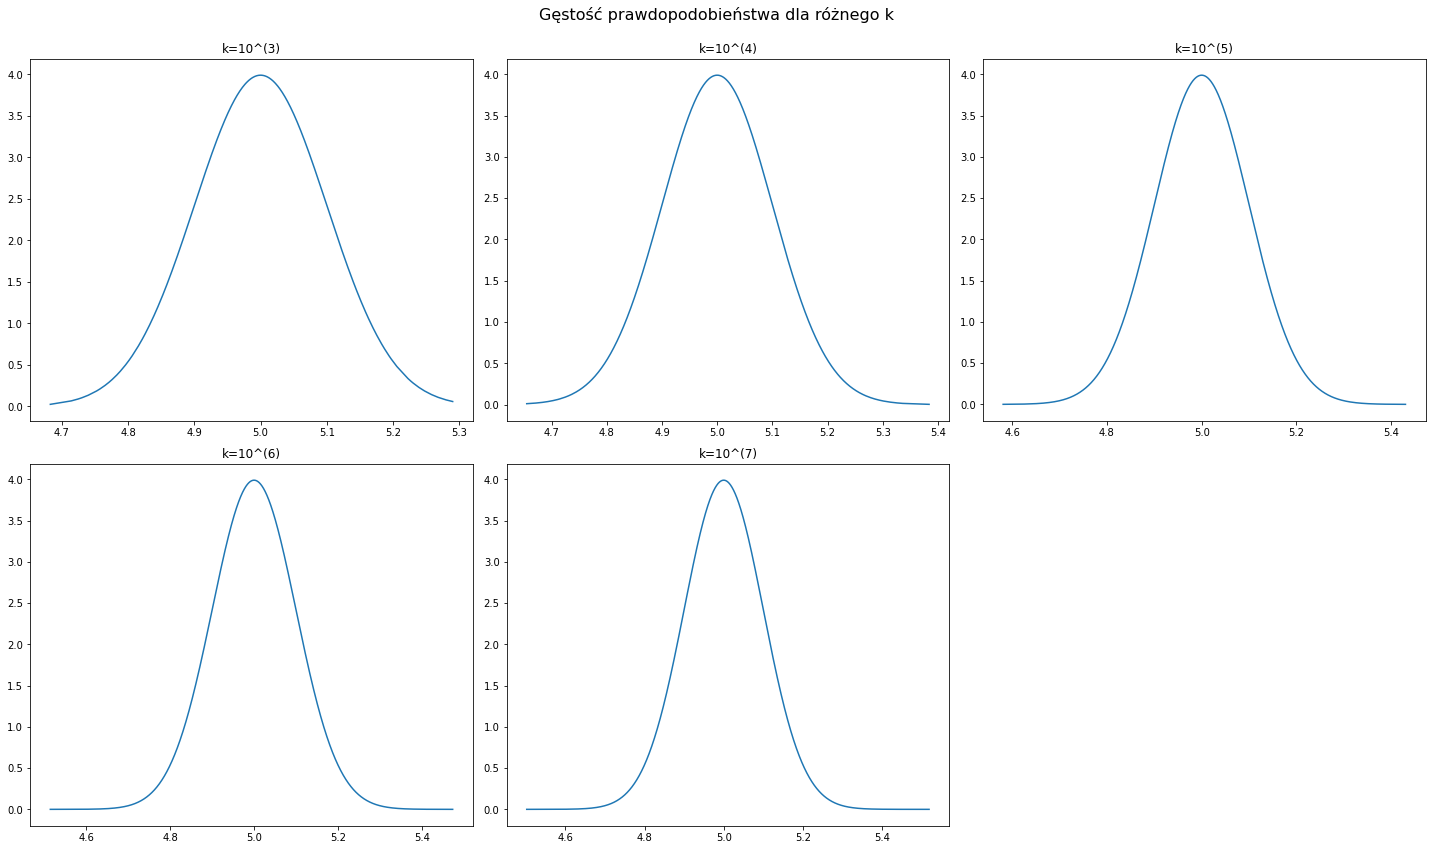

In [110]:
fig, axarr = plt.subplots(2, 3)
fig.set_figheight(12)
fig.set_figwidth(20)
fig.suptitle("Gęstość prawdopodobieństwa dla różnego k", fontsize=16)

axarr[0, 0].plot(np.sort(samples_k_3), probability_pdf(samples_k_3))
axarr[0, 0].set_title('k=10^(3)')
axarr[0, 1].plot(np.sort(samples_k_4), probability_pdf(samples_k_4))
axarr[0, 1].set_title('k=10^(4)')
axarr[0, 2].plot(np.sort(samples_k_5), probability_pdf(samples_k_5))
axarr[0, 2].set_title('k=10^(5)')
axarr[1, 0].plot(np.sort(samples_k_6), probability_pdf(samples_k_6))
axarr[1, 0].set_title('k=10^(6)')
axarr[1, 1].plot(np.sort(samples_k_7), probability_pdf(samples_k_7))
axarr[1, 1].set_title('k=10^(7)')
axarr[1, 2].set_visible(False)

# Tight layout often produces nice results
# but requires the title to be spaced accordingly
fig.tight_layout()
fig.subplots_adjust(top=0.92)

plt.show()

### Obliczenie dystrybuanty

<b>Dystrybuanta</b> - (ang. cumulative distribution function) to funkcja matematyczna, która określa prawdopodobieństwo, że losowo wybrana zmienna losowa X jest mniejsza lub równa danej wartości x, tzn. F(x) = P(X $\leq$ x). Dystrybuanta może być użyta do określenia takich wartości jak kwantyle (np. mediana) oraz do badania asymetrii i ogona rozkładu zmiennej losowej.

$$ F(x) = \frac{1}{2}\left[1 + \operatorname{erf}\left(\frac{x-\mu}{\sigma\sqrt{2}}\right)\right] $$

Podobnie jak dla obliczenia gęstości prawdopodobieństwa najpierw należało skorzystać z posortowanych wcześniej danych w tablicy <font color=yellow>samples</font>
https://stackoverflow.com/questions/24788200/calculate-the-cumulative-distribution-function-cdf-in-python

In [111]:
def norm_cdf(samples):
    sort_samples = np.sort(samples)
    norm_cdf = norm.cdf(sort_samples, mu, sigma)
    return norm_cdf

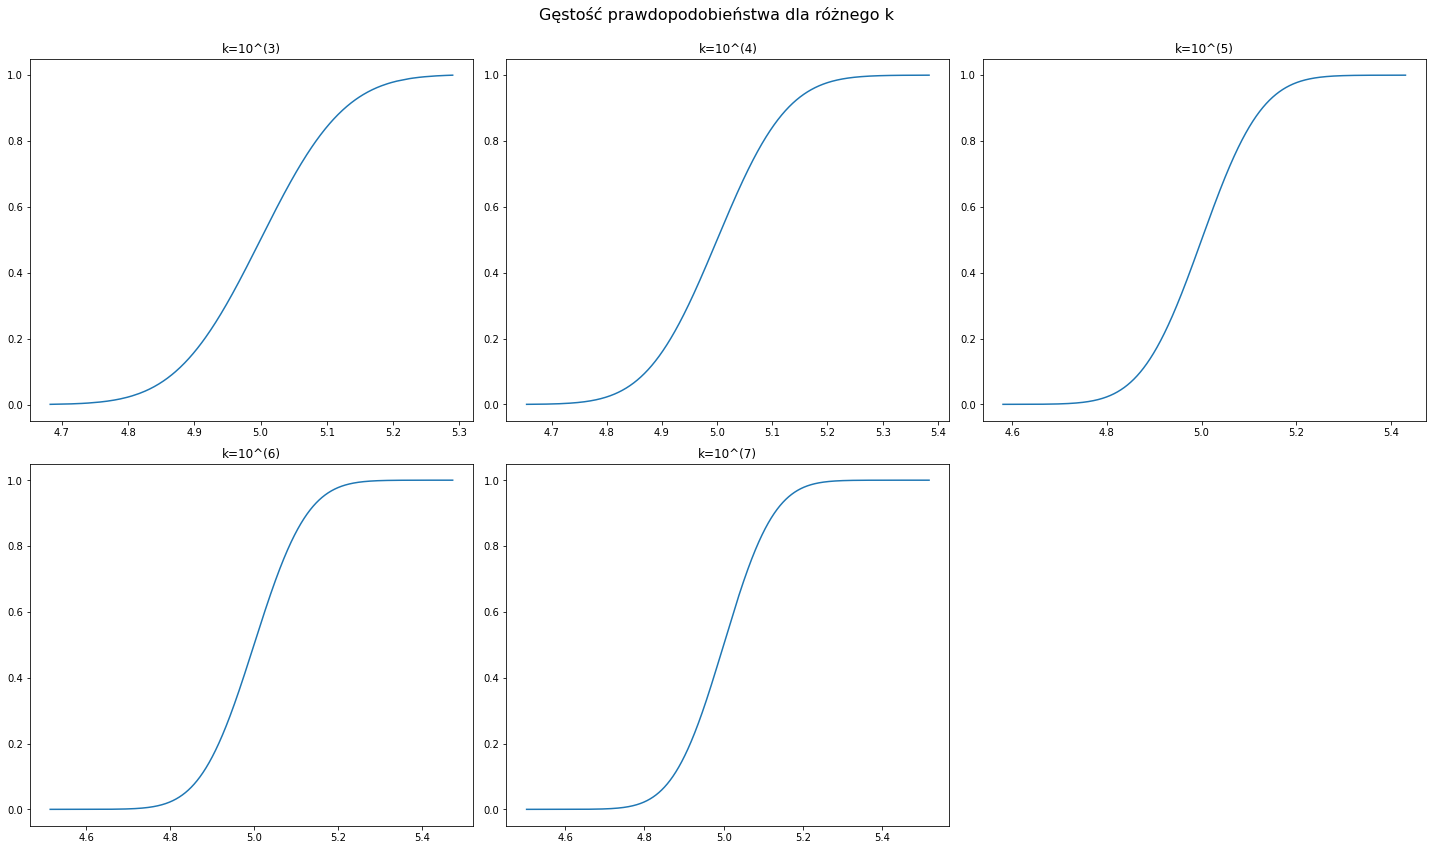

In [112]:
fig, axarr = plt.subplots(2, 3)
fig.set_figheight(12)
fig.set_figwidth(20)
fig.suptitle("Gęstość prawdopodobieństwa dla różnego k", fontsize=16)

axarr[0, 0].plot(np.sort(samples_k_3), norm_cdf(samples_k_3))
axarr[0, 0].set_title('k=10^(3)')
axarr[0, 1].plot(np.sort(samples_k_4), norm_cdf(samples_k_4))
axarr[0, 1].set_title('k=10^(4)')
axarr[0, 2].plot(np.sort(samples_k_5), norm_cdf(samples_k_5))
axarr[0, 2].set_title('k=10^(5)')
axarr[1, 0].plot(np.sort(samples_k_6), norm_cdf(samples_k_6))
axarr[1, 0].set_title('k=10^(6)')
axarr[1, 1].plot(np.sort(samples_k_7), norm_cdf(samples_k_7))
axarr[1, 1].set_title('k=10^(7)')
axarr[1, 2].set_visible(False)

# Tight layout often produces nice results
# but requires the title to be spaced accordingly
fig.tight_layout()
fig.subplots_adjust(top=0.92)

plt.show()

### Obliczenie wartości oczekiwanej

<b>Wartość oczekiwana</b> - (ang. expected value) to średnia wartość zmiennej losowej X. Można ją wyznaczyć przez pomnożenie każdej wartości zmiennej losowej przez jej prawdopodobieństwo i zsumowanie tych wartości. Wartość oczekiwana jest jednym z najważniejszych parametrów opisujących zmienną losową, ponieważ pozwala na określenie, jakiej wartości można oczekiwać, gdy zmienna losowa zostanie wielokrotnie pomierzona.

$$ E(X) = \int_{-\infty}^{\infty} x f(x) dx $$

Wytłumaczone na filmiku jak w pythonie obliczać wartość oczekiwaną oraz wariancję
https://www.youtube.com/watch?v=ikcUBqELZVU

In [113]:
#Dla k=10^(3)
expected_value_k1 = describe(samples_k_3).mean
#Dla k=10^(4)
expected_value_k2 = describe(samples_k_4).mean
#Dla k=10^(5)
expected_value_k3 = describe(samples_k_5).mean
#Dla k=10^(6)
expected_value_k4 = describe(samples_k_6).mean
#Dla k=10^(7)
expected_value_k5 = describe(samples_k_7).mean

### Obliczenie wariancji

<b>Wariancja</b> - w procesach stochastycznych to miara zmienności losowej zmiennej w czasie. Jest to średnia arytmetyczna kwadratów odchyleń wartości losowej zmiennej od jej wartości oczekiwanej w ciągu określonego czasu. Innymi słowy, wariancja procesu stochastycznego mierzy, jak bardzo zmieniają się wartości zmiennej losowej w czasie, i określa, jak bardzo trajektoria procesu różni się od średniej trajektorii. Im większa wariancja, tym większa zmienność w trajektorii procesu, a tym samym większa szansa na wystąpienie dużych odchyleń od wartości oczekiwanej. Wariancja jest jednym z podstawowych parametrów charakteryzujących proces stochastyczny i jest istotnym narzędziem w analizie i modelowaniu procesów losowych. W praktyce, często używa się także odchylenia standardowego, które jest pierwiastkiem kwadratowym z wariancji i wyraża się w tych samych jednostkach co zmienna losowa.


$$ \operatorname{Var}(X) = E\left[(X - E(X))^2\right] = \int_{-\infty}^{\infty} (x - E(X))^2 f(x) dx $$

In [114]:
#Dla k=10^(3)
variance_k1 = describe(samples_k_3).variance
#Dla k=10^(4)
variance_k2 = describe(samples_k_4).variance
#Dla k=10^(5)
variance_k3 = describe(samples_k_5).variance
#Dla k=10^(6)
variance_k4 = describe(samples_k_6).variance
#Dla k=10^(7)
variance_k5 = describe(samples_k_7).variance

Podsumowanie obliczeń wartości oczekiwanej oraz kowariancji względem różnych k

In [115]:
dict = {'k' : ['k^(3)', 'k^(4)', 'k^(5)', 'k^(6)', 'k^(7)'],
        'wartość oczekiwana' : [expected_value_k1, expected_value_k2, expected_value_k3, expected_value_k4, expected_value_k5],
        'wariancja' : [variance_k1, variance_k2, variance_k3, variance_k4, variance_k5]}

df = pd.DataFrame(dict)

df.style

,k,wartość oczekiwana,wariancja
0,k^(3),4.992919,0.009493
1,k^(4),5.000000,0.010109
2,k^(5),4.999877,0.010039
3,k^(6),5.000104,0.010000
4,k^(7),5.000038,0.010007


### Obliczenie funkcji kowariancyjnej

<b>Funkcja kowariancyjna</b> - (ang. covariance function) to funkcja, która opisuje zależność między dwiema zmiennymi losowymi X i Y. Funkcja kowariancyjna określa, czy zmienne losowe X i Y są skorelowane (czy zmieniają się razem) lub niezależne (czy zmieniają się niezależnie od siebie). W przypadku zmiennych losowych niezależnych funkcja kowariancyjna wynosi 0, a w przypadku zmiennych losowych skorelowanych funkcja kowariancyjna może być dodatnia lub ujemna.

$$ \operatorname{Cov}(X_i, X_j) = \begin{cases} \sigma^2 & i = j \\ 0 & i \neq j \end{cases} $$

gdzie X_i i X_j to próbki szumu białego, a σ^2 to wariancja szumu białego.

In [116]:
def covariance(samples, k):
    # Subtitute DC component noise signal from samples
    subtitute_mu_value = samples - mu
    # Compute covariance function
    cov = np.correlate(subtitute_mu_value, subtitute_mu_value, mode='full') / k
    return cov

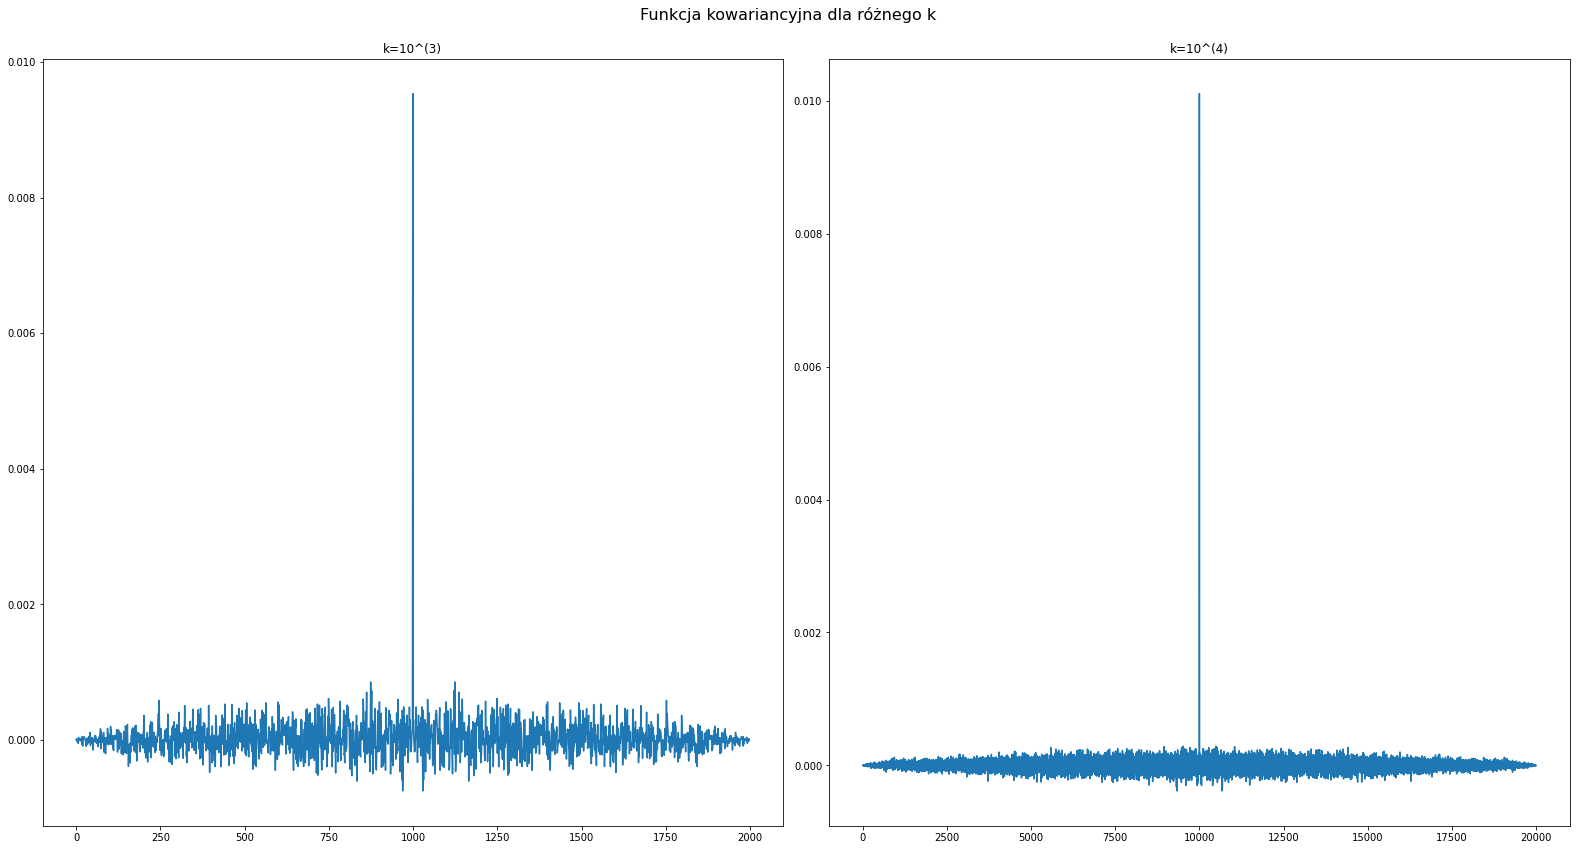

In [117]:
fig, axarr = plt.subplots(1, 2)
fig.set_figheight(12)
fig.set_figwidth(22)
fig.suptitle("Funkcja kowariancyjna dla różnego k", fontsize=16)

axarr[0].plot(covariance(samples_k_3, k_3))
axarr[0].set_title('k=10^(3)')
axarr[1].plot(covariance(samples_k_4, k_4))
axarr[1].set_title('k=10^(4)')

# Tight layout often produces nice results
# but requires the title to be spaced accordingly
fig.tight_layout()
fig.subplots_adjust(top=0.92)

plt.show()

## 3. Przeprowadzić filtrację danych z wykorzystaniem filtru dolnoprzepustowego FIR (SOJ) o różnych parametrach

In [118]:
def calculate_impulse_response(numtaps, filter):
    # Tworzenie impulsu jednostkowego
    impulse = np.zeros(numtaps)
    impulse[numtaps // 2] = 1
    
    # Obliczanie odpowiedzi impulsowej filtru FIR
    impulse_response = signal.convolve(impulse, filter, mode='full')
    
    return impulse_response

def filtration(noise, cutoff_param):
    # definicja filtra dolnoprzepustowego FIR (SOJ) o różnych parametrach
    fs = 5000  # częstotliwość próbkowania 5 kHz
    filter1 = signal.firwin(numtaps=11, cutoff=cutoff_param, fs=fs, window='hamming')
    filter2 = signal.firwin(numtaps=31, cutoff=cutoff_param, fs=fs, window='hamming')
    filter3 = signal.firwin(numtaps=51, cutoff=cutoff_param, fs=fs, window='hamming')

    # przeprowadzenie filtracji danych z wykorzystaniem filtrów
    filtered1 = signal.convolve(noise, filter1, mode='same')
    filtered2 = signal.convolve(noise, filter2, mode='same')
    filtered3 = signal.convolve(noise, filter3, mode='same')

    fig, axs = plt.subplots(3, 2, figsize=(15, 8))

    axs[0, 0].plot(noise, label='Szum biały')
    axs[0, 0].plot(filtered1, label='Filtr dolnoprzepustowy FIR (SOJ) o 11 punktach')
    axs[0, 0].set_title("Filtracja filtrem dolnoprzepustowym FIR (SOJ) o 11 punktach")
    axs[0, 0].legend()

    axs[1, 0].plot(noise, label='Szum biały')
    axs[1, 0].plot(filtered2, label='Filtr dolnoprzepustowy FIR (SOJ) o 31 punktach')
    axs[1, 0].set_title("Filtracja filtrem dolnoprzepustowym FIR (SOJ) o 31 punktach")
    axs[1, 0].legend()

    axs[2, 0].plot(noise, label='Szum biały')
    axs[2, 0].plot(filtered3, label='Filtr dolnoprzepustowy FIR (SOJ) o 51 punktach')
    axs[2, 0].set_title("Filtracja filtrem dolnoprzepustowym FIR (SOJ) o 51 punktach")
    axs[2, 0].legend()
    
    impulse_response1 = calculate_impulse_response(11, filter1)
    axs[0, 1].stem(impulse_response1)
    axs[0, 1].set_title("Odpowiedź impulsowa filtru FIR (SOJ) o 11 punktach")
    
    impulse_response2 = calculate_impulse_response(31, filter2)
    axs[1, 1].stem(impulse_response2)
    axs[1, 1].set_title("Odpowiedź impulsowa filtru FIR (SOJ) o 31 punktach")
    
    impulse_response3 = calculate_impulse_response(51, filter3)
    axs[2, 1].stem(impulse_response3)
    axs[2, 1].set_title("Odpowiedź impulsowa filtru FIR (SOJ) o 51 punktach")
    
    fig.tight_layout()
    
    plt.show()

    return filtered3

### Dla k=10^(3)

#### fcutoff=300Hz

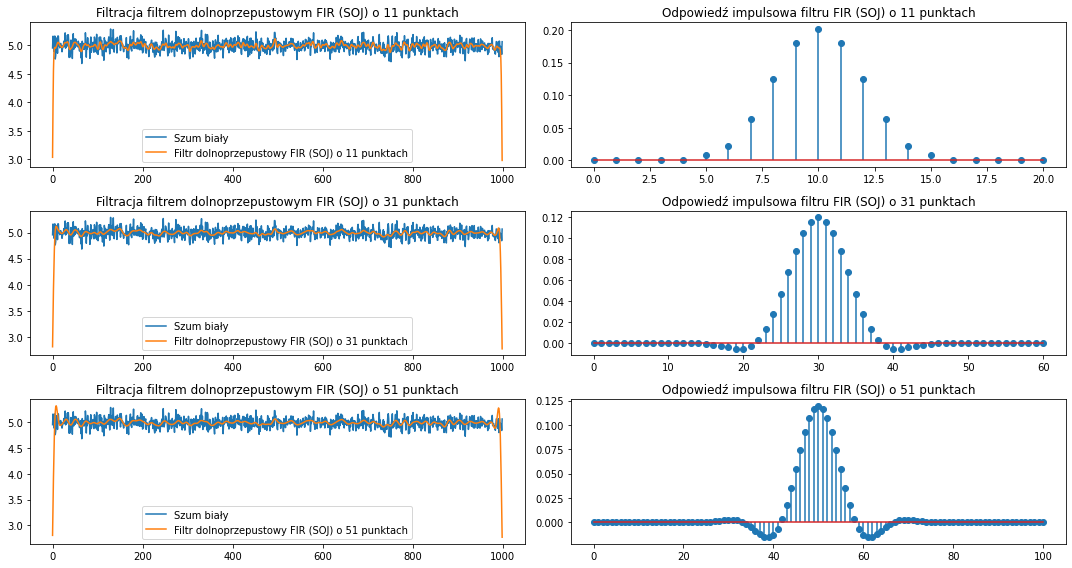

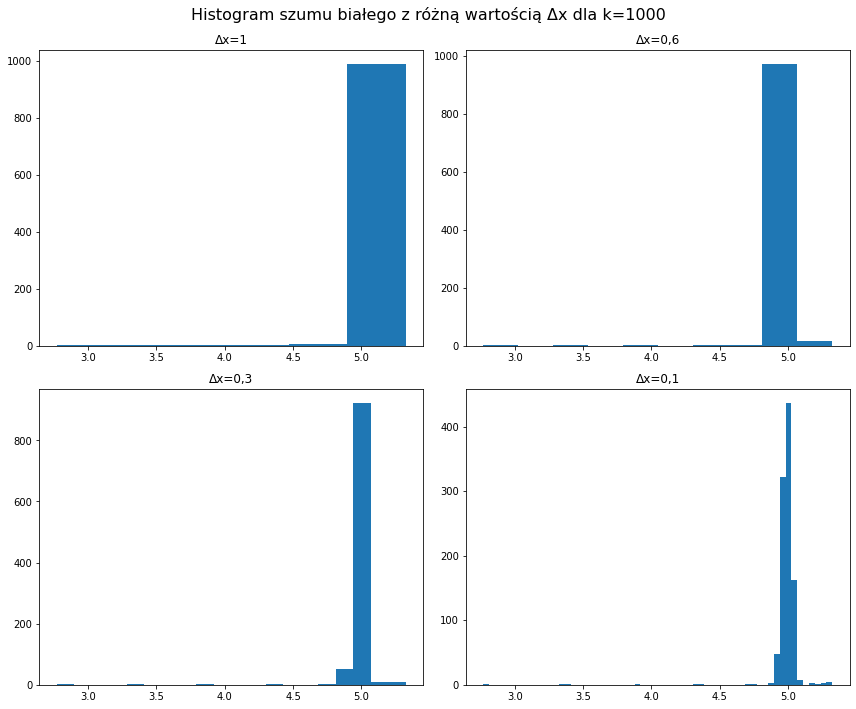

In [119]:
noise_after_filtration_k3_fc300 = filtration(samples_k_3, 300)
display_hist(noise_after_filtration_k3_fc300, k_3)

#### fcutoff=900Hz

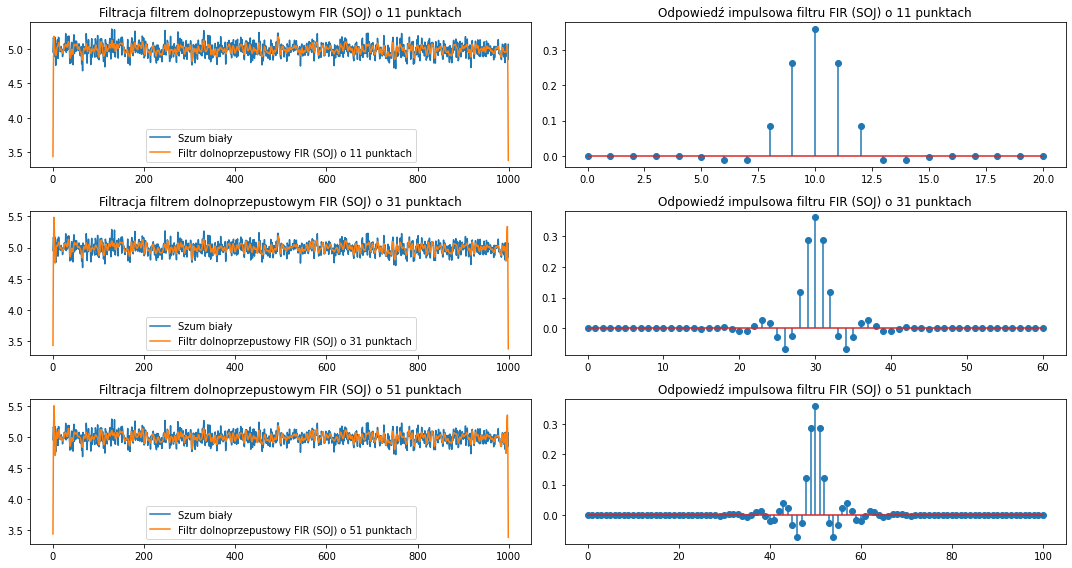

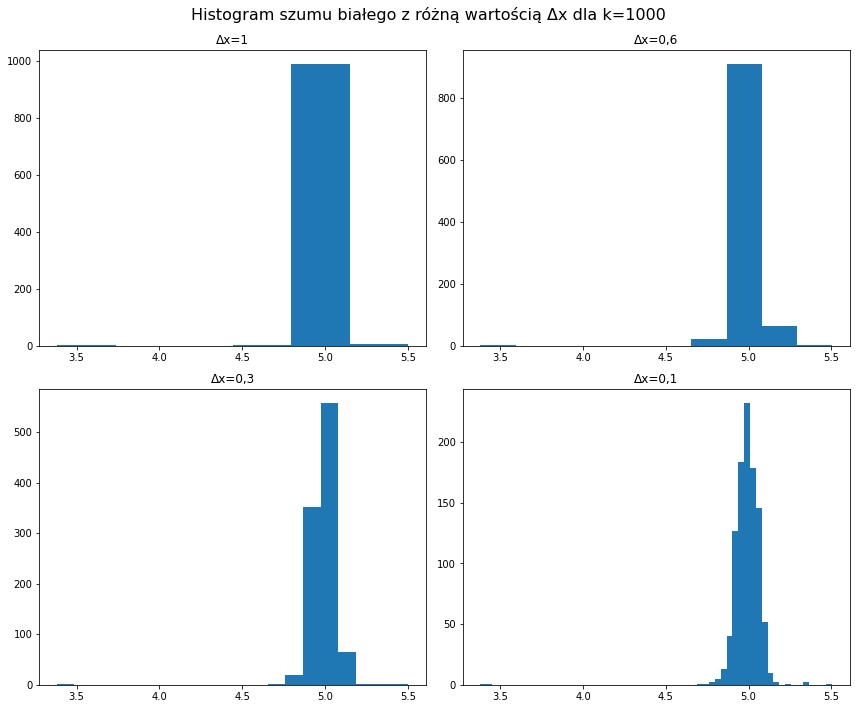

In [120]:
noise_after_filtration_k3_fc900 = filtration(samples_k_3, 900)
display_hist(noise_after_filtration_k3_fc900, k_3)

#### fcutoff=1600Hz

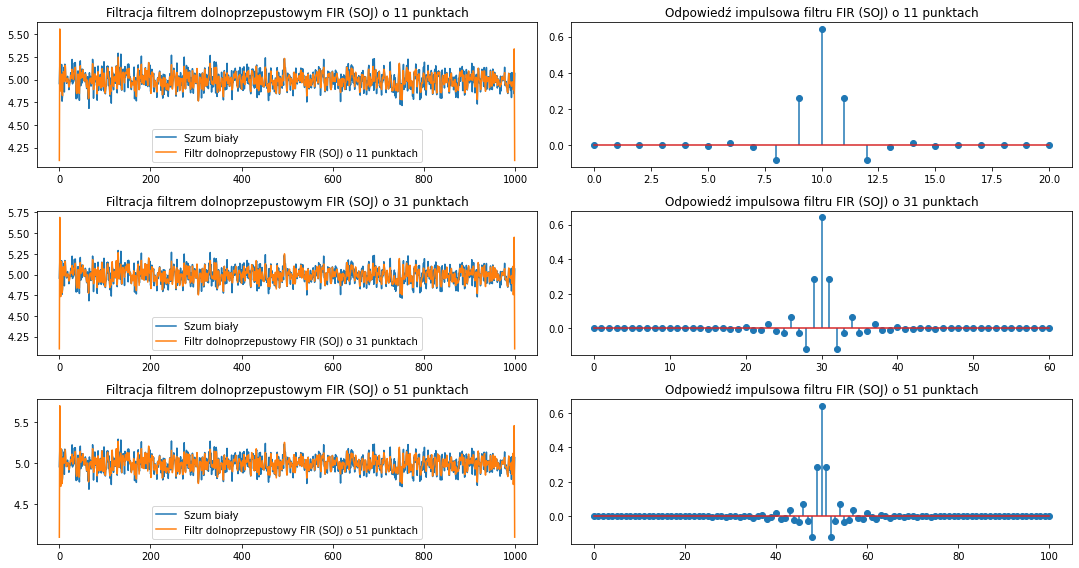

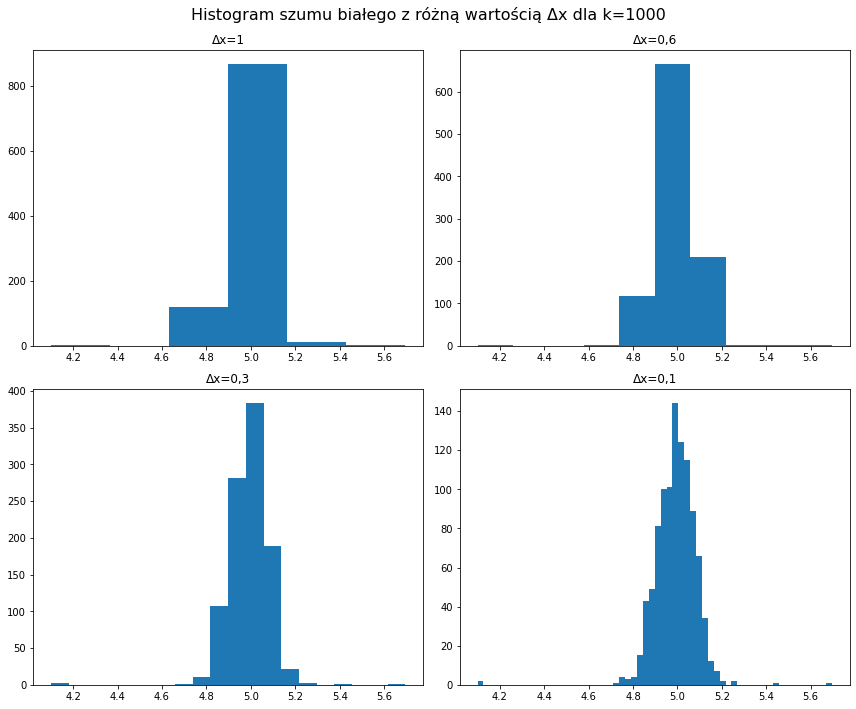

In [121]:
noise_after_filtration_k3_fc1600 = filtration(samples_k_3, 1600)
display_hist(noise_after_filtration_k3_fc1600, k_3)

### Dla k=10^(4)

#### fcutoff=300

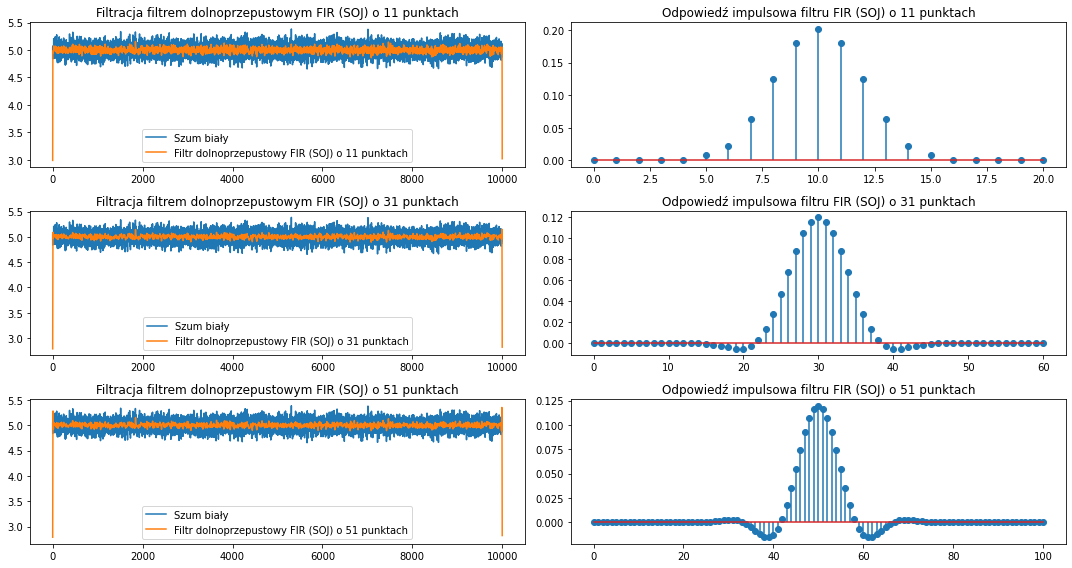

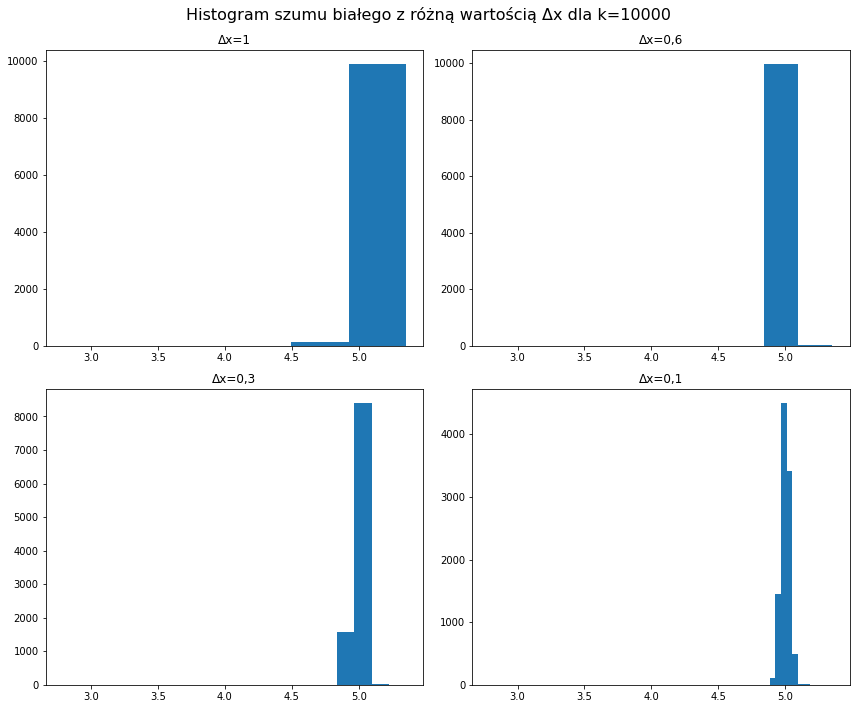

In [122]:
noise_after_filtration_k4_fc300 = filtration(samples_k_4, 300)
display_hist(noise_after_filtration_k4_fc300, k_4)

#### fcutoff=900

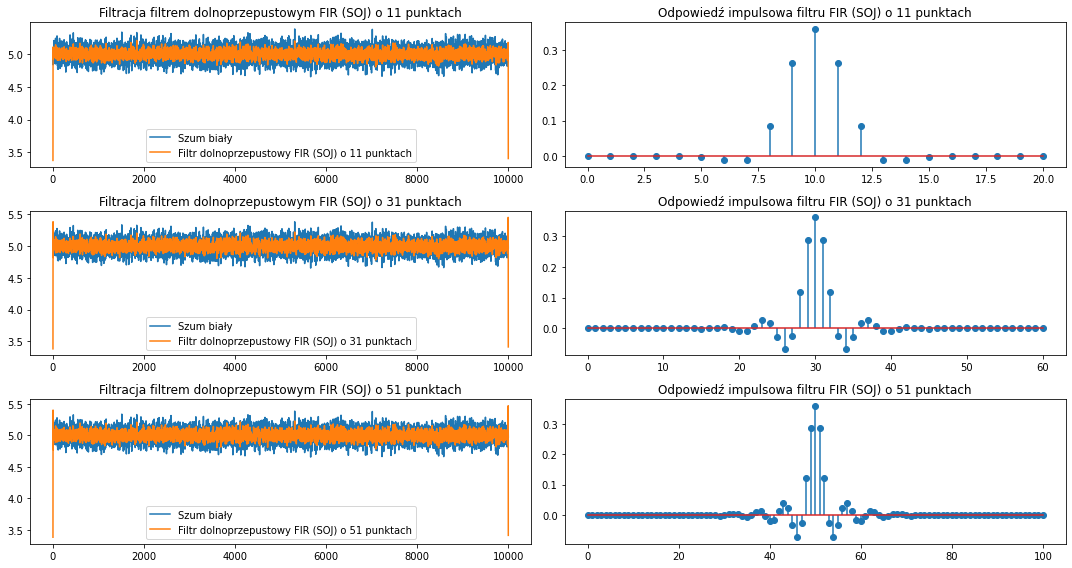

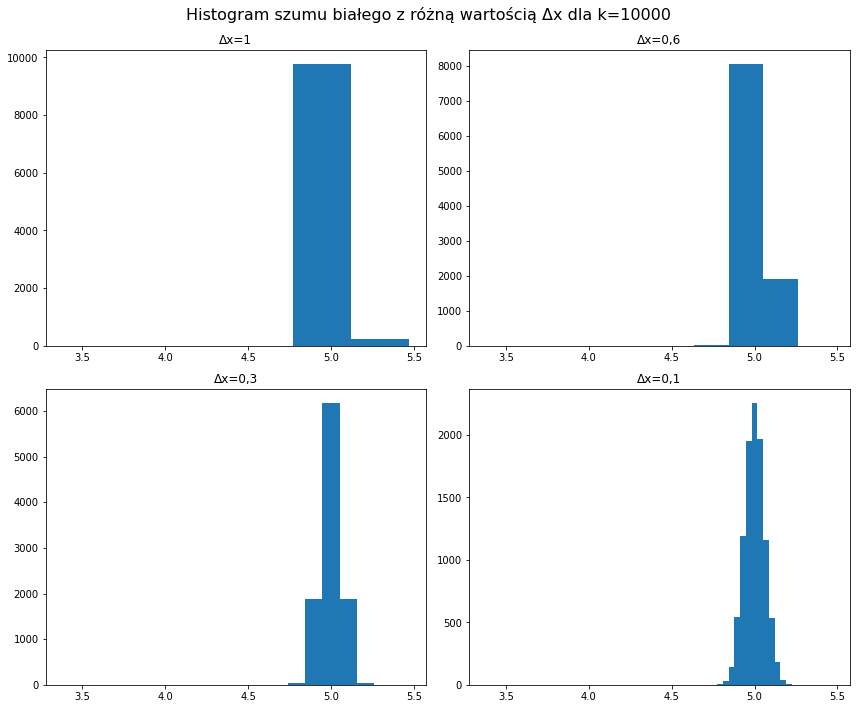

In [123]:
noise_after_filtration_k4_fc900 = filtration(samples_k_4, 900)
display_hist(noise_after_filtration_k4_fc900, k_4)

#### fcutoff=1600

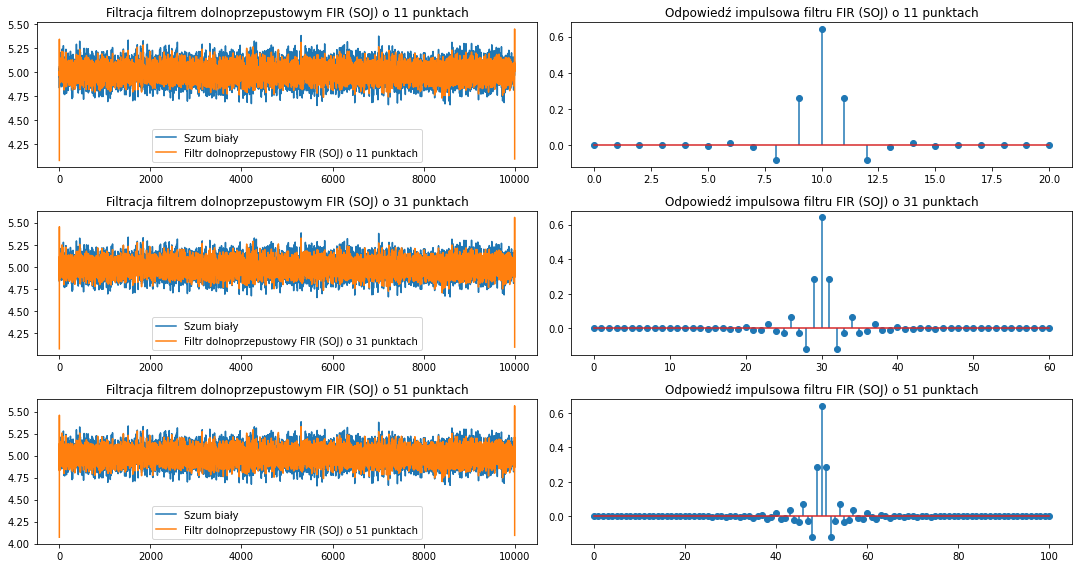

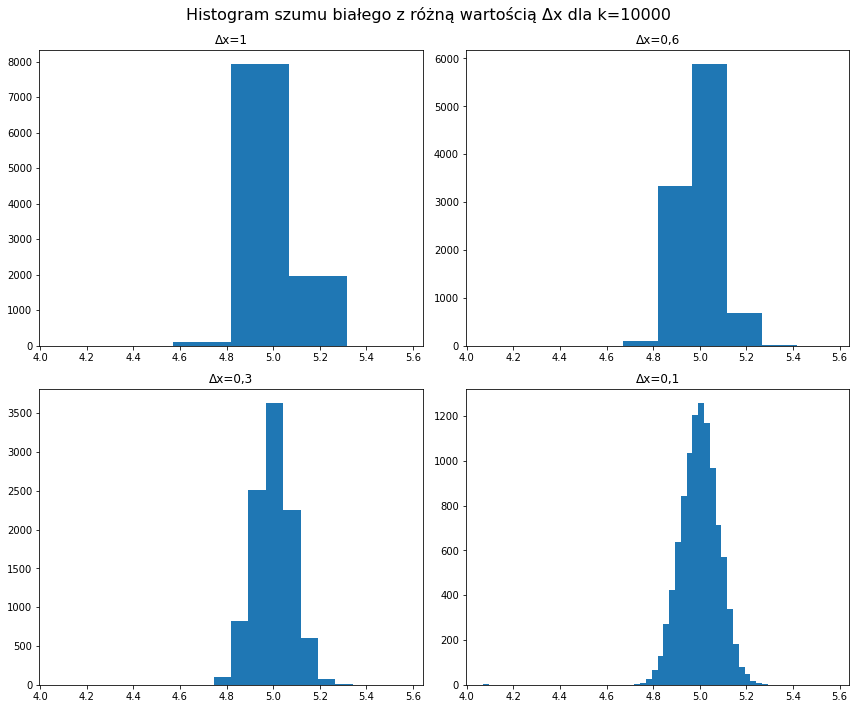

In [124]:
noise_after_filtration_k4_fc1600 = filtration(samples_k_4, 1600)
display_hist(noise_after_filtration_k4_fc1600, k_4)

### Dla k=10^(5)

#### fcutoff=300

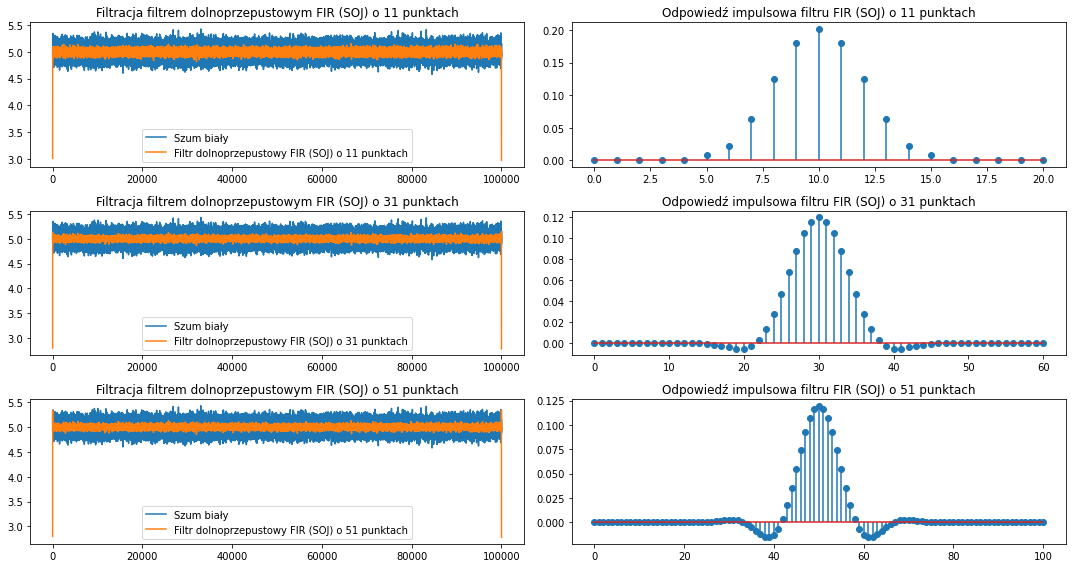

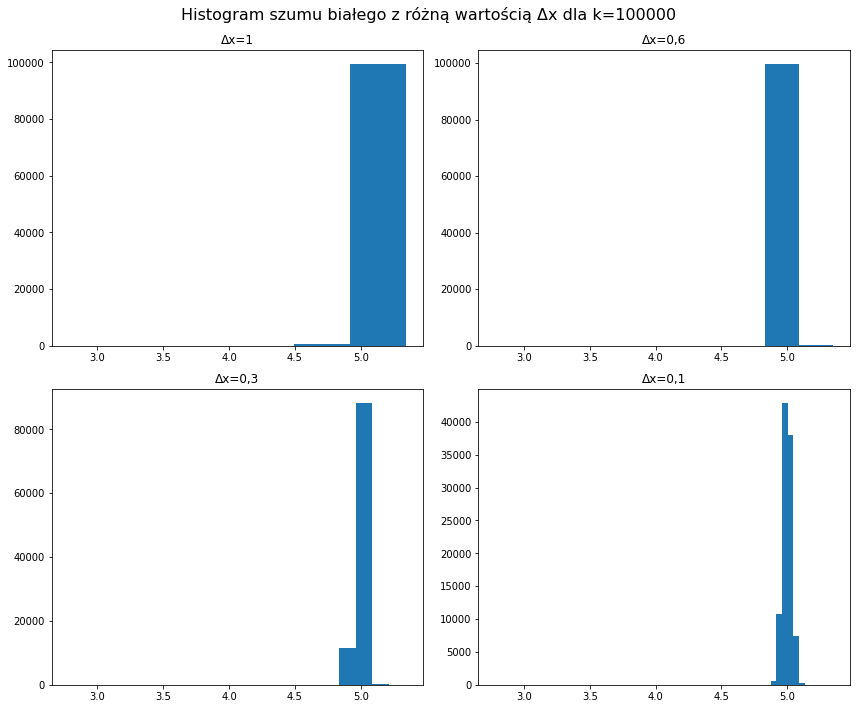

In [125]:
noise_after_filtration_k5_fc300 = filtration(samples_k_5, 300)
display_hist(noise_after_filtration_k5_fc300, k_5)

#### fcutoff=900

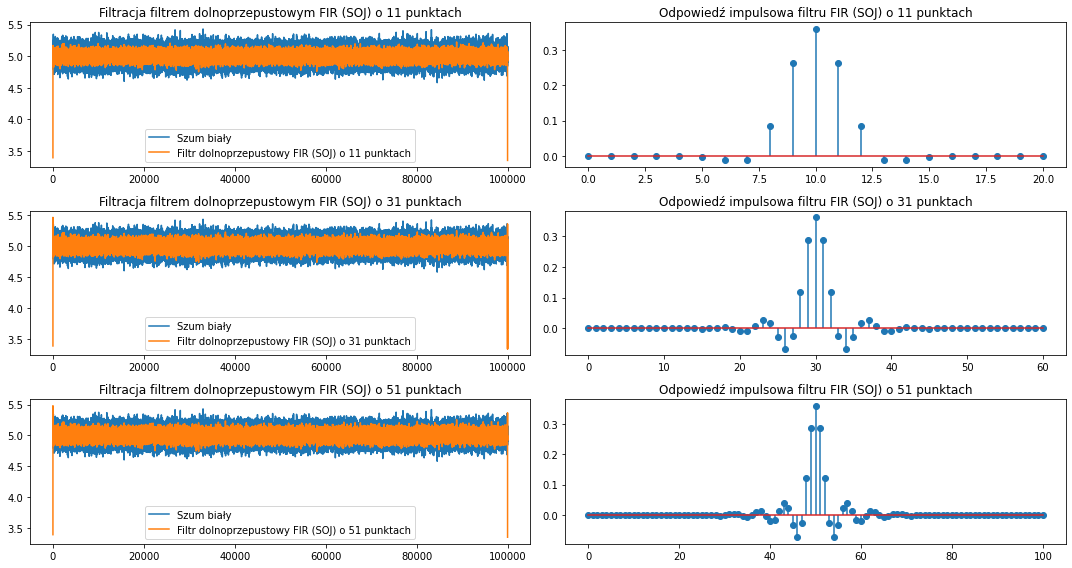

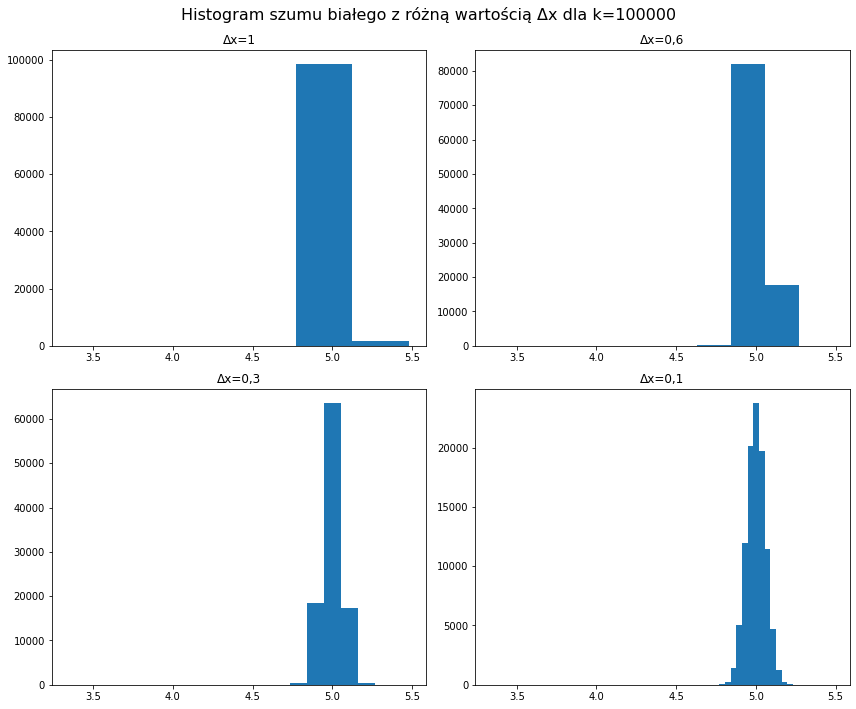

In [126]:
noise_after_filtration_k5_fc900 = filtration(samples_k_5, 900)
display_hist(noise_after_filtration_k5_fc900, k_5)

#### fcutoff=1600

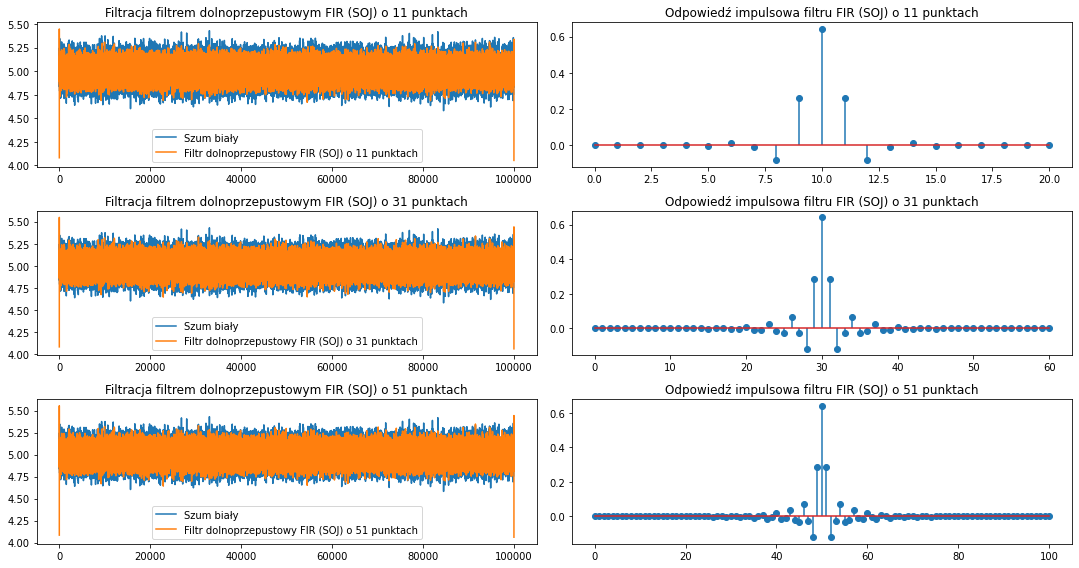

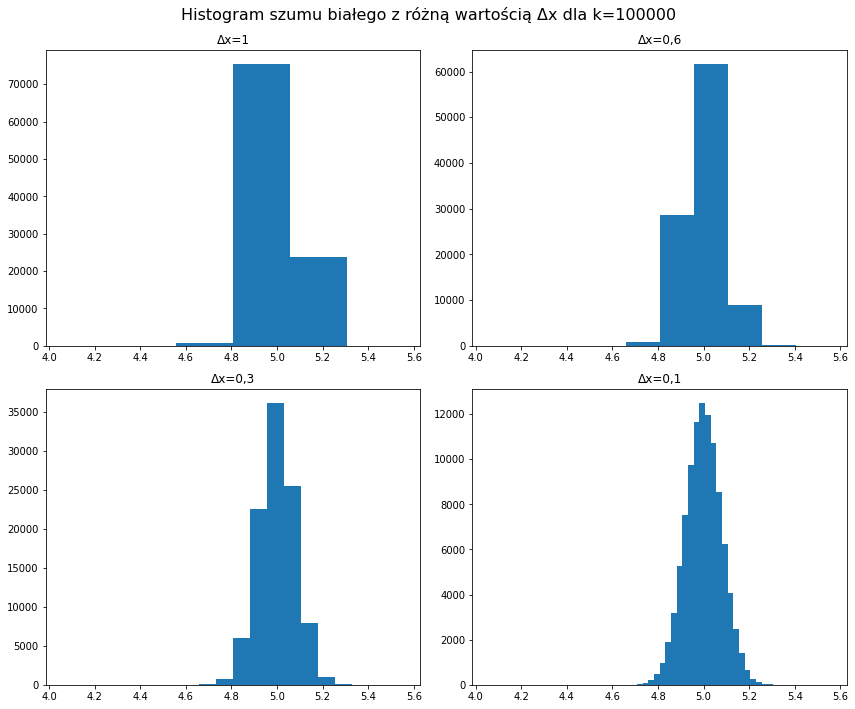

In [127]:
noise_after_filtration_k5_fc1600 = filtration(samples_k_5, 1600)
display_hist(noise_after_filtration_k5_fc1600, k_5)

### Dla k=10^(6)

#### fcutoff=300

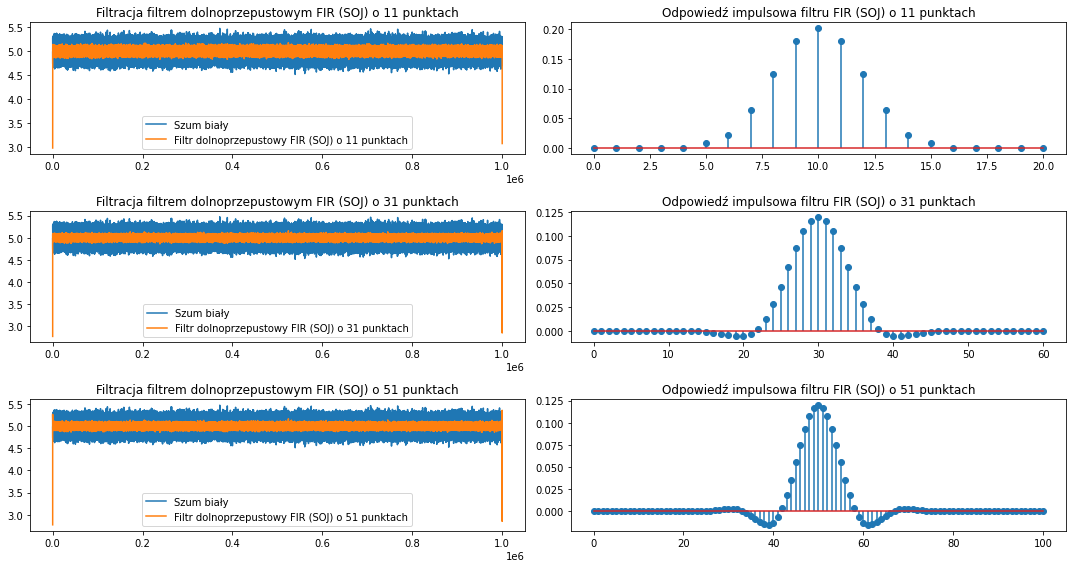

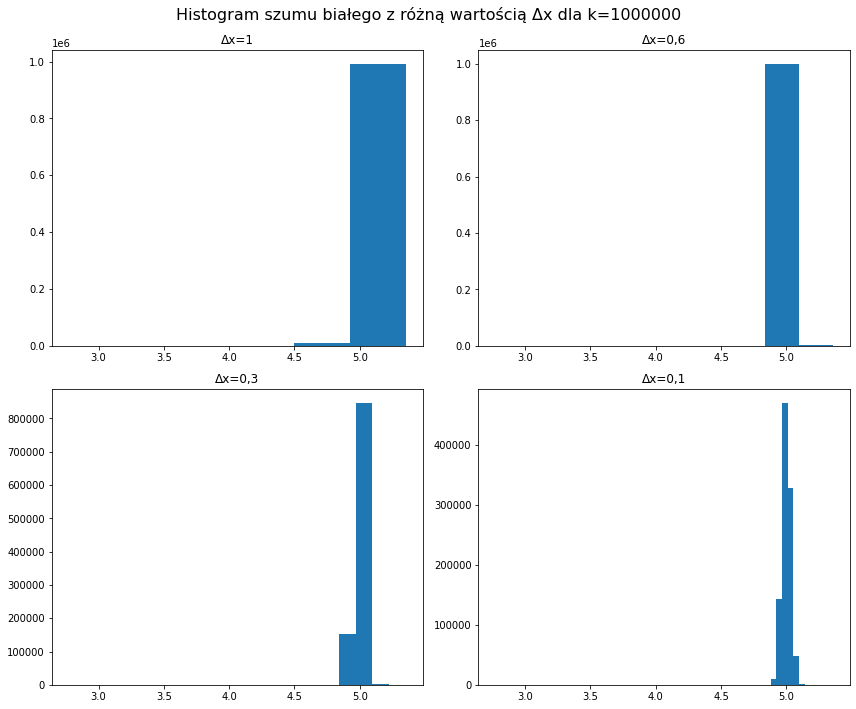

In [128]:
noise_after_filtration_k6_fc300 = filtration(samples_k_6, 300)
display_hist(noise_after_filtration_k6_fc300, k_6)

#### fcutoff=900

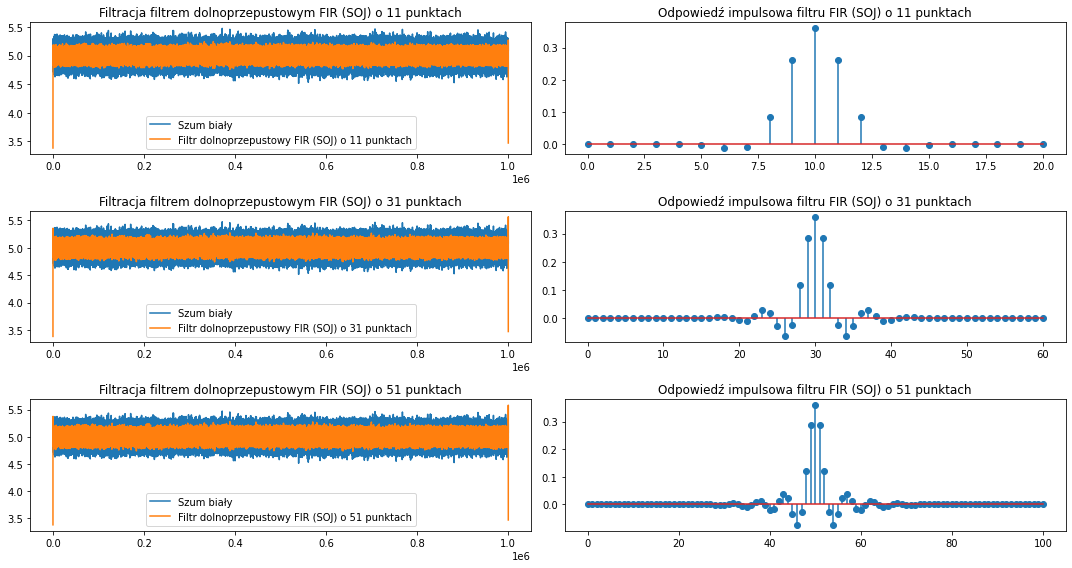

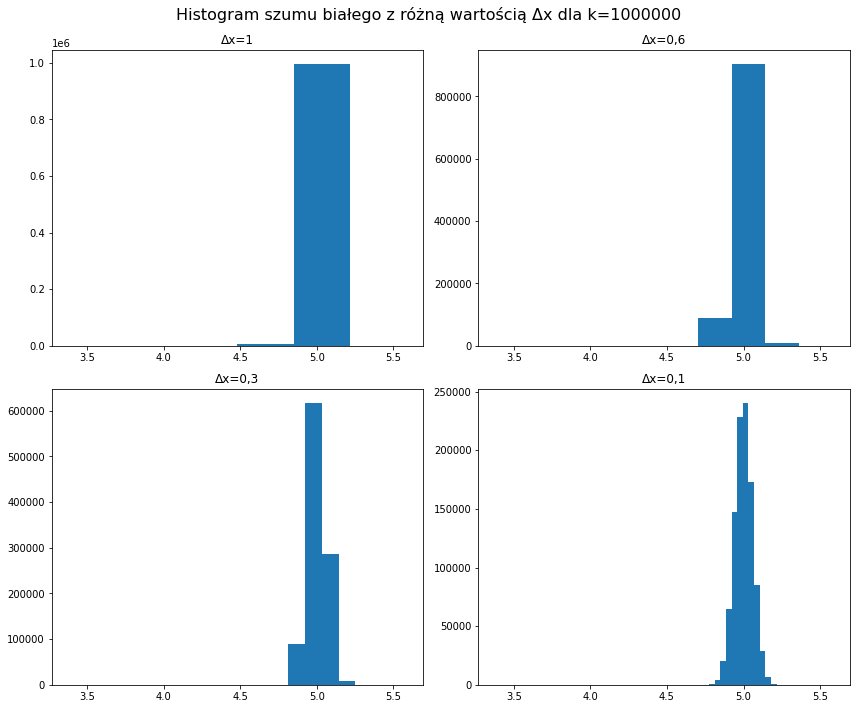

In [129]:
noise_after_filtration_k6_fc900 = filtration(samples_k_6, 900)
display_hist(noise_after_filtration_k6_fc900, k_6)

#### fcutoff=1600

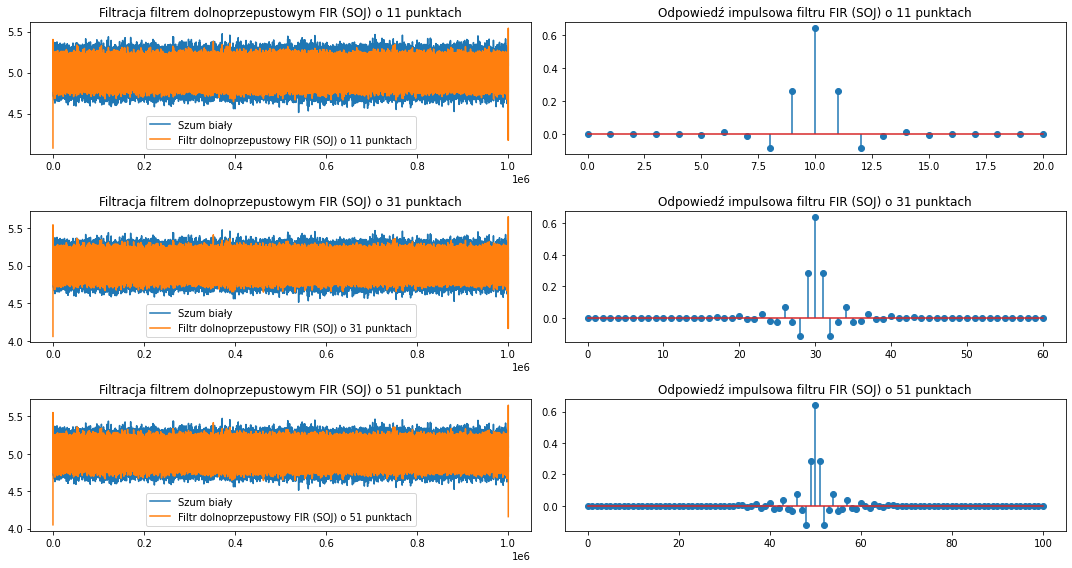

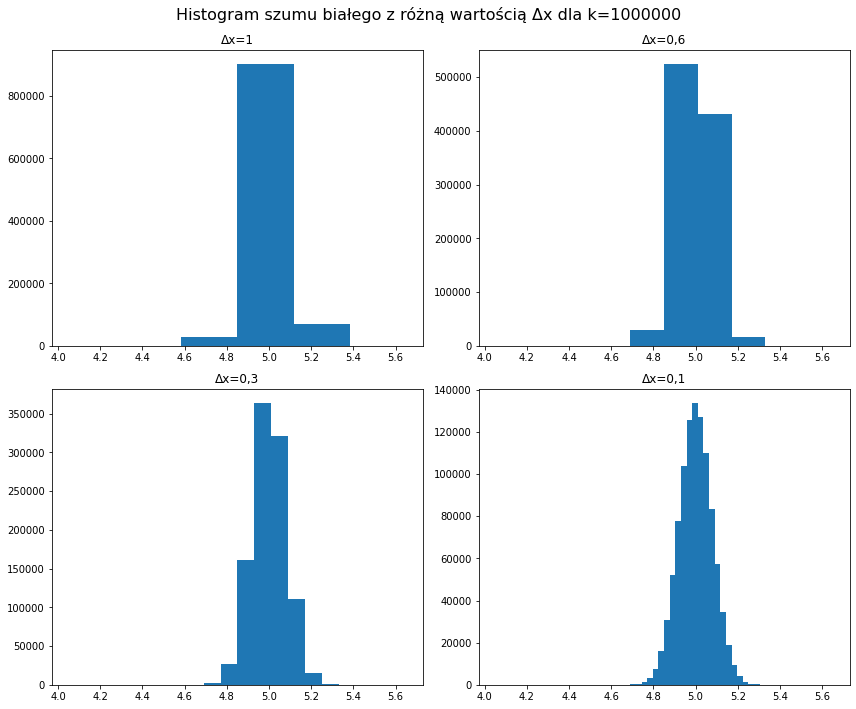

In [130]:
noise_after_filtration_k6_fc1600 = filtration(samples_k_6, 1600)
display_hist(noise_after_filtration_k6_fc1600, k_6)

#### Dla k=10^(7)

#### fcutoff=300

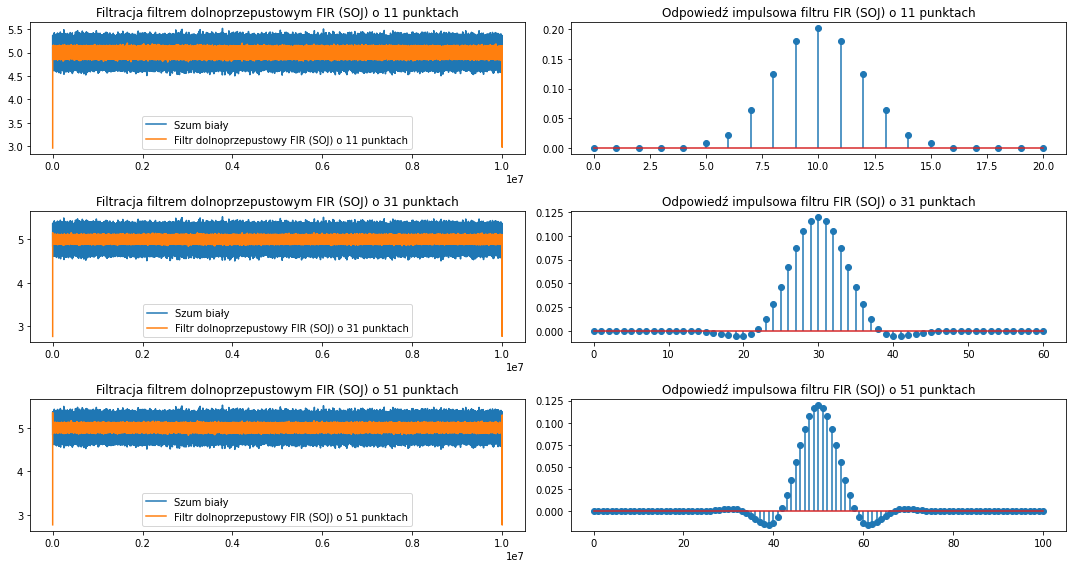

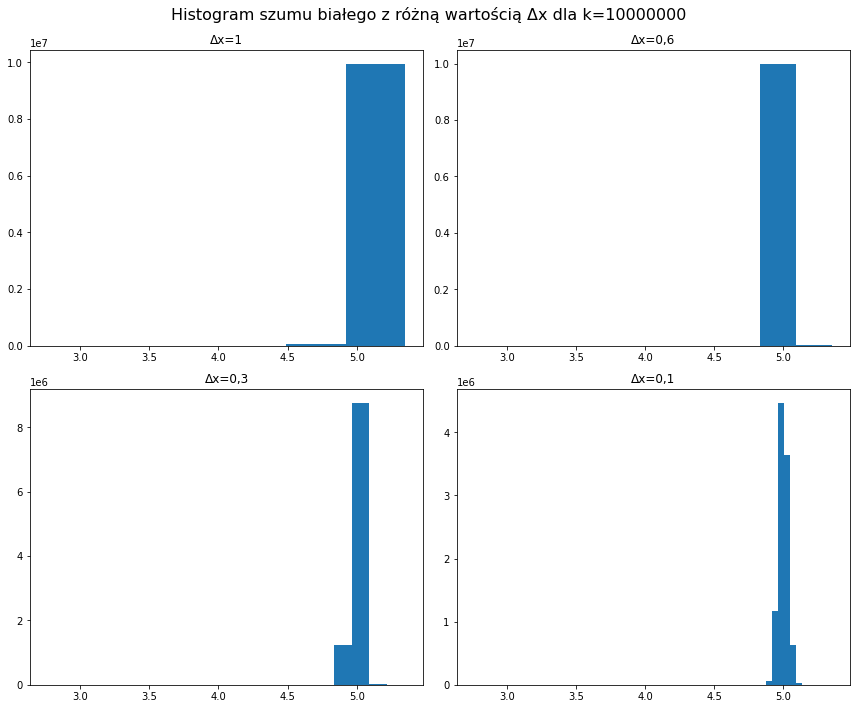

In [131]:
noise_after_filtration_k7_fc300 = filtration(samples_k_7, 300)
display_hist(noise_after_filtration_k7_fc300, k_7)

#### fcutoff=900

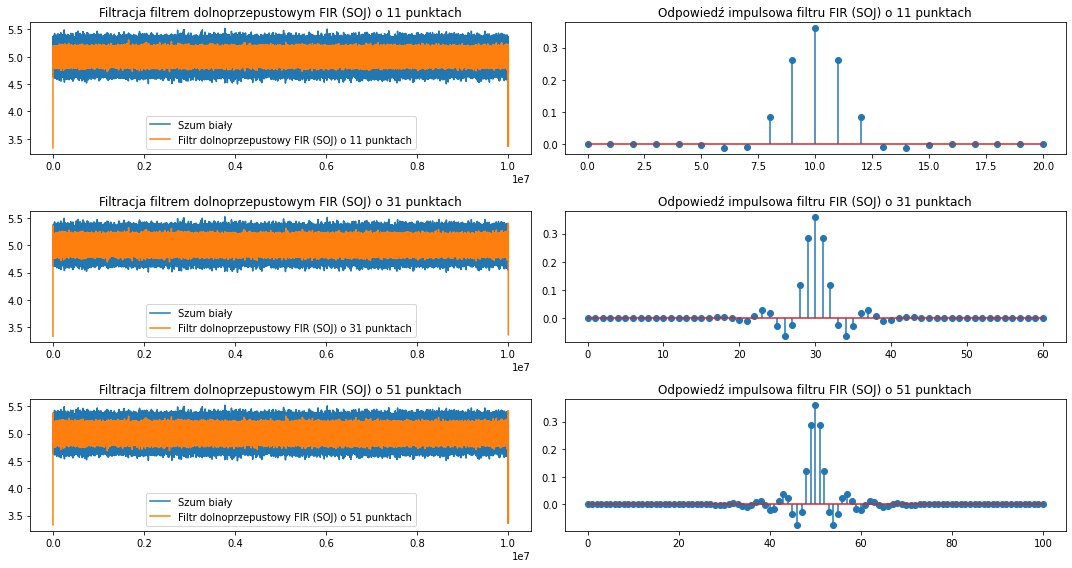

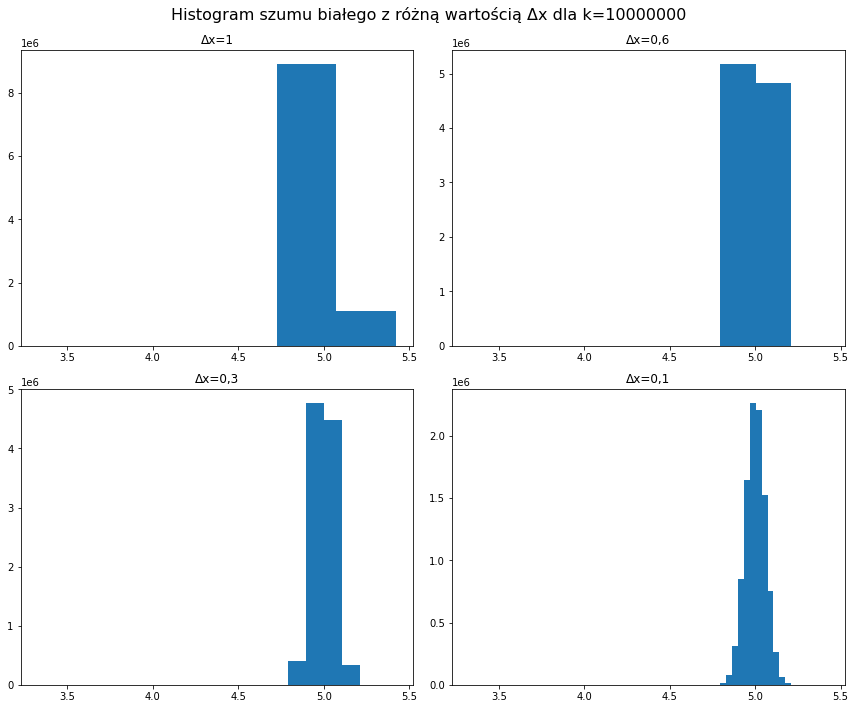

In [132]:
noise_after_filtration_k7_fc900 = filtration(samples_k_7, 900)
display_hist(noise_after_filtration_k7_fc900, k_7)

#### fcutoff=1600

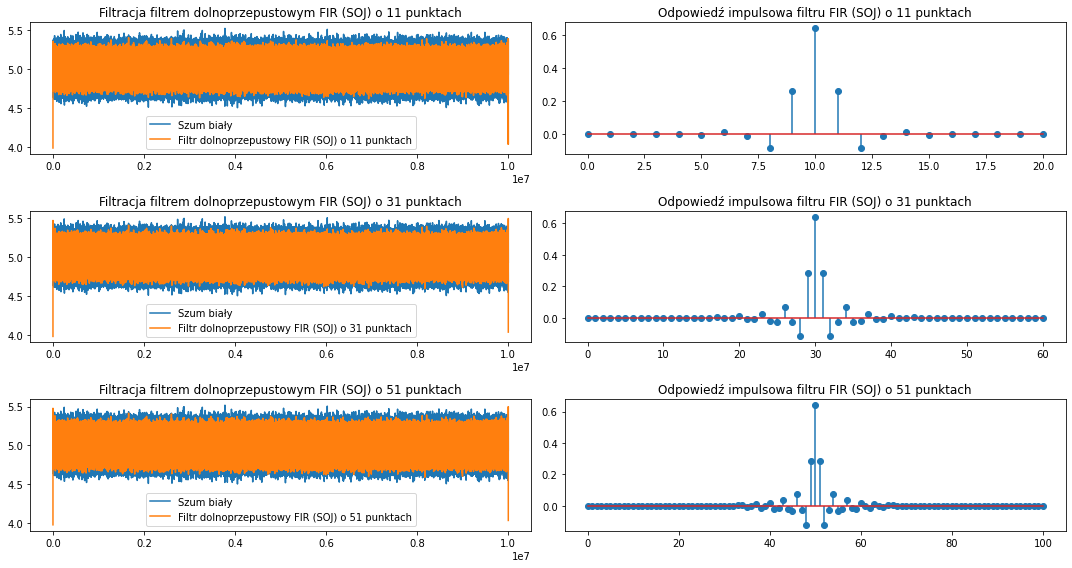

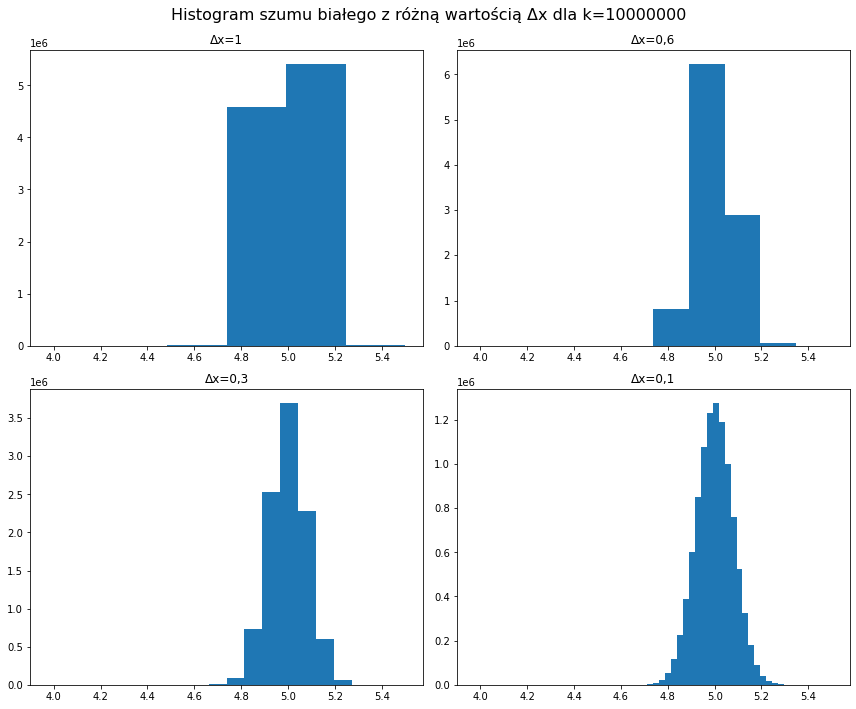

In [133]:
noise_after_filtration_k7_fc1600 = filtration(samples_k_7, 1600)
display_hist(noise_after_filtration_k7_fc1600, k_7)

## 4. Obliczyć gęstość prawdopodobieństwa, dystrybuantę, a też wartość oczekiwaną, wariancję i funkcję kowariancyjną sygnału wyjściowego. Porównać wyniki z p 2.

### Obliczenie gęstości prawdopodobieństwa

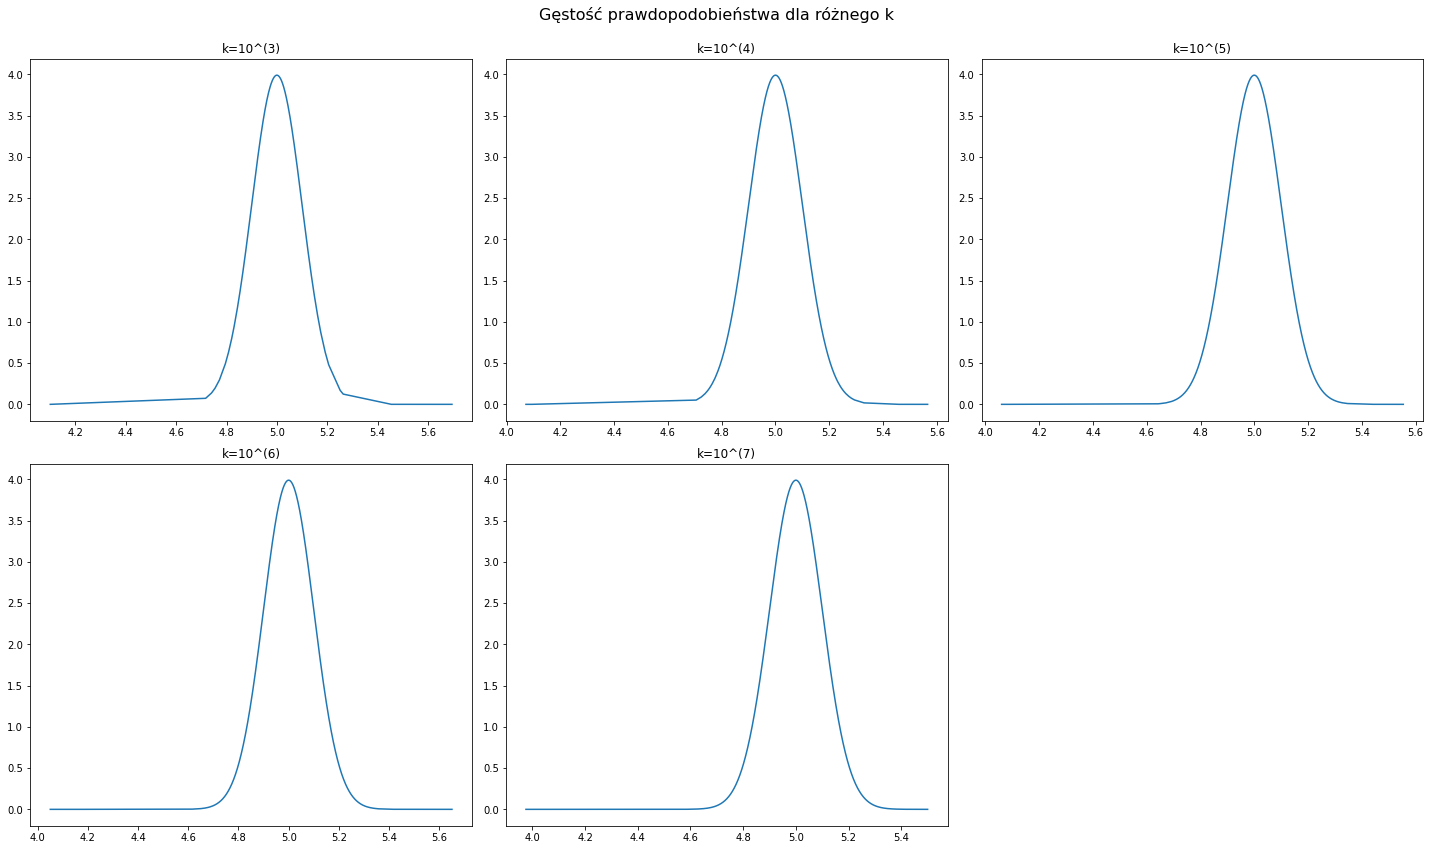

In [134]:
fig, axarr = plt.subplots(2, 3)
fig.set_figheight(12)
fig.set_figwidth(20)
fig.suptitle("Gęstość prawdopodobieństwa dla różnego k", fontsize=16)

axarr[0, 0].plot(np.sort(noise_after_filtration_k3_fc1600), probability_pdf(noise_after_filtration_k3_fc1600))
axarr[0, 0].set_title('k=10^(3)')
axarr[0, 1].plot(np.sort(noise_after_filtration_k4_fc1600), probability_pdf(noise_after_filtration_k4_fc1600))
axarr[0, 1].set_title('k=10^(4)')
axarr[0, 2].plot(np.sort(noise_after_filtration_k5_fc1600), probability_pdf(noise_after_filtration_k5_fc1600))
axarr[0, 2].set_title('k=10^(5)')
axarr[1, 0].plot(np.sort(noise_after_filtration_k6_fc1600), probability_pdf(noise_after_filtration_k6_fc1600))
axarr[1, 0].set_title('k=10^(6)')
axarr[1, 1].plot(np.sort(noise_after_filtration_k7_fc1600), probability_pdf(noise_after_filtration_k7_fc1600))
axarr[1, 1].set_title('k=10^(7)')
axarr[1, 2].set_visible(False)

# Tight layout often produces nice results
# but requires the title to be spaced accordingly
fig.tight_layout()
fig.subplots_adjust(top=0.92)

plt.show()

### Obliczenie dystrybuanty

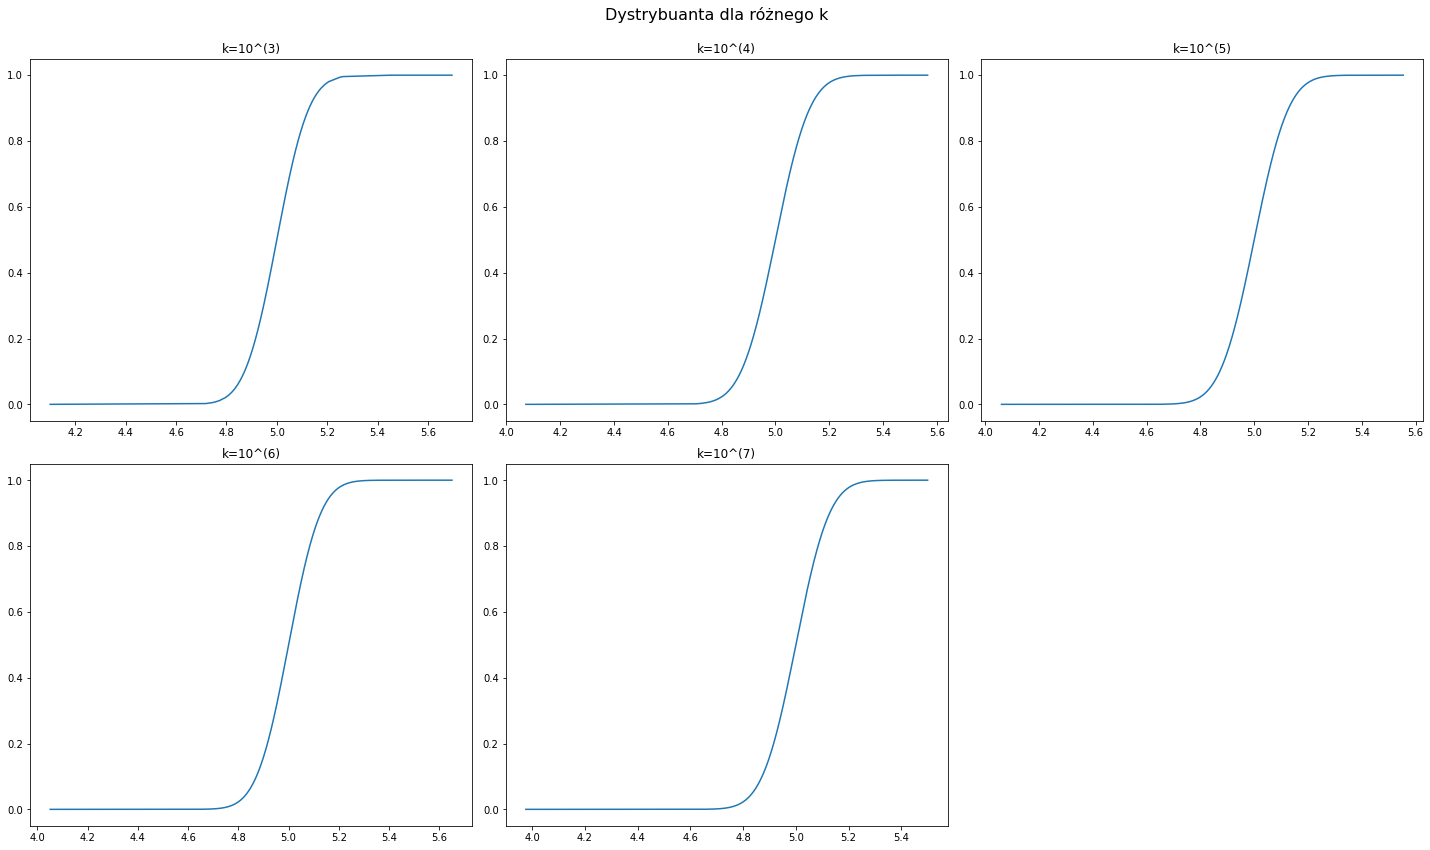

In [136]:
fig, axarr = plt.subplots(2, 3)
fig.set_figheight(12)
fig.set_figwidth(20)
fig.suptitle("Dystrybuanta dla różnego k", fontsize=16)

axarr[0, 0].plot(np.sort(noise_after_filtration_k3_fc1600), norm_cdf(noise_after_filtration_k3_fc1600))
axarr[0, 0].set_title('k=10^(3)')
axarr[0, 1].plot(np.sort(noise_after_filtration_k4_fc1600), norm_cdf(noise_after_filtration_k4_fc1600))
axarr[0, 1].set_title('k=10^(4)')
axarr[0, 2].plot(np.sort(noise_after_filtration_k5_fc1600), norm_cdf(noise_after_filtration_k5_fc1600))
axarr[0, 2].set_title('k=10^(5)')
axarr[1, 0].plot(np.sort(noise_after_filtration_k6_fc1600), norm_cdf(noise_after_filtration_k6_fc1600))
axarr[1, 0].set_title('k=10^(6)')
axarr[1, 1].plot(np.sort(noise_after_filtration_k7_fc1600), norm_cdf(noise_after_filtration_k7_fc1600))
axarr[1, 1].set_title('k=10^(7)')
axarr[1, 2].set_visible(False)

# Tight layout often produces nice results
# but requires the title to be spaced accordingly
fig.tight_layout()
fig.subplots_adjust(top=0.92)

plt.show()

### Obliczenie wartości oczekiwanej

In [141]:
#Dla k=10^(3)
expected_value_k1_after_filtration = describe(noise_after_filtration_k3_fc1600).mean
#Dla k=10^(4)
expected_value_k2_after_filtration = describe(noise_after_filtration_k4_fc1600).mean
#Dla k=10^(5)
expected_value_k3_after_filtration = describe(noise_after_filtration_k5_fc1600).mean
#Dla k=10^(6)
expected_value_k4_after_filtration = describe(noise_after_filtration_k6_fc1600).mean
#Dla k=10^(7)
expected_value_k5_after_filtration = describe(noise_after_filtration_k7_fc1600).mean

### Obliczenie wariancji

In [142]:
#Dla k=10^(3)
variance_k1_after_filtration = describe(noise_after_filtration_k3_fc1600).variance
#Dla k=10^(4)
variance_k2_after_filtration = describe(noise_after_filtration_k4_fc1600).variance
#Dla k=10^(5)
variance_k3_after_filtration = describe(noise_after_filtration_k5_fc1600).variance
#Dla k=10^(6)
variance_k4_after_filtration = describe(noise_after_filtration_k6_fc1600).variance
#Dla k=10^(7)
variance_k5_after_filtration = describe(noise_after_filtration_k7_fc1600).variance

Podsumowanie obliczeń wartości oczekiwanej oraz kowariancji względem różnych k

In [145]:
dict = {'k' : ['k^(3)', 'k^(4)', 'k^(5)', 'k^(6)', 'k^(7)'],
        'wartość oczekiwana' : [expected_value_k1_after_filtration, expected_value_k2_after_filtration, expected_value_k3_after_filtration, expected_value_k4_after_filtration, expected_value_k5_after_filtration],
        'wariancja' : [variance_k1_after_filtration, variance_k2_after_filtration, variance_k3_after_filtration, variance_k4_after_filtration, variance_k5_after_filtration]}

df = pd.DataFrame(dict)

df.style

,k,wartość oczekiwana,wariancja
0,k^(3),4.991985,0.008481
1,k^(4),4.999904,0.006546
2,k^(5),4.999868,0.006326
3,k^(6),5.000103,0.006246
4,k^(7),5.000038,0.006256


### Obliczenie funkcji kowariancyjnej

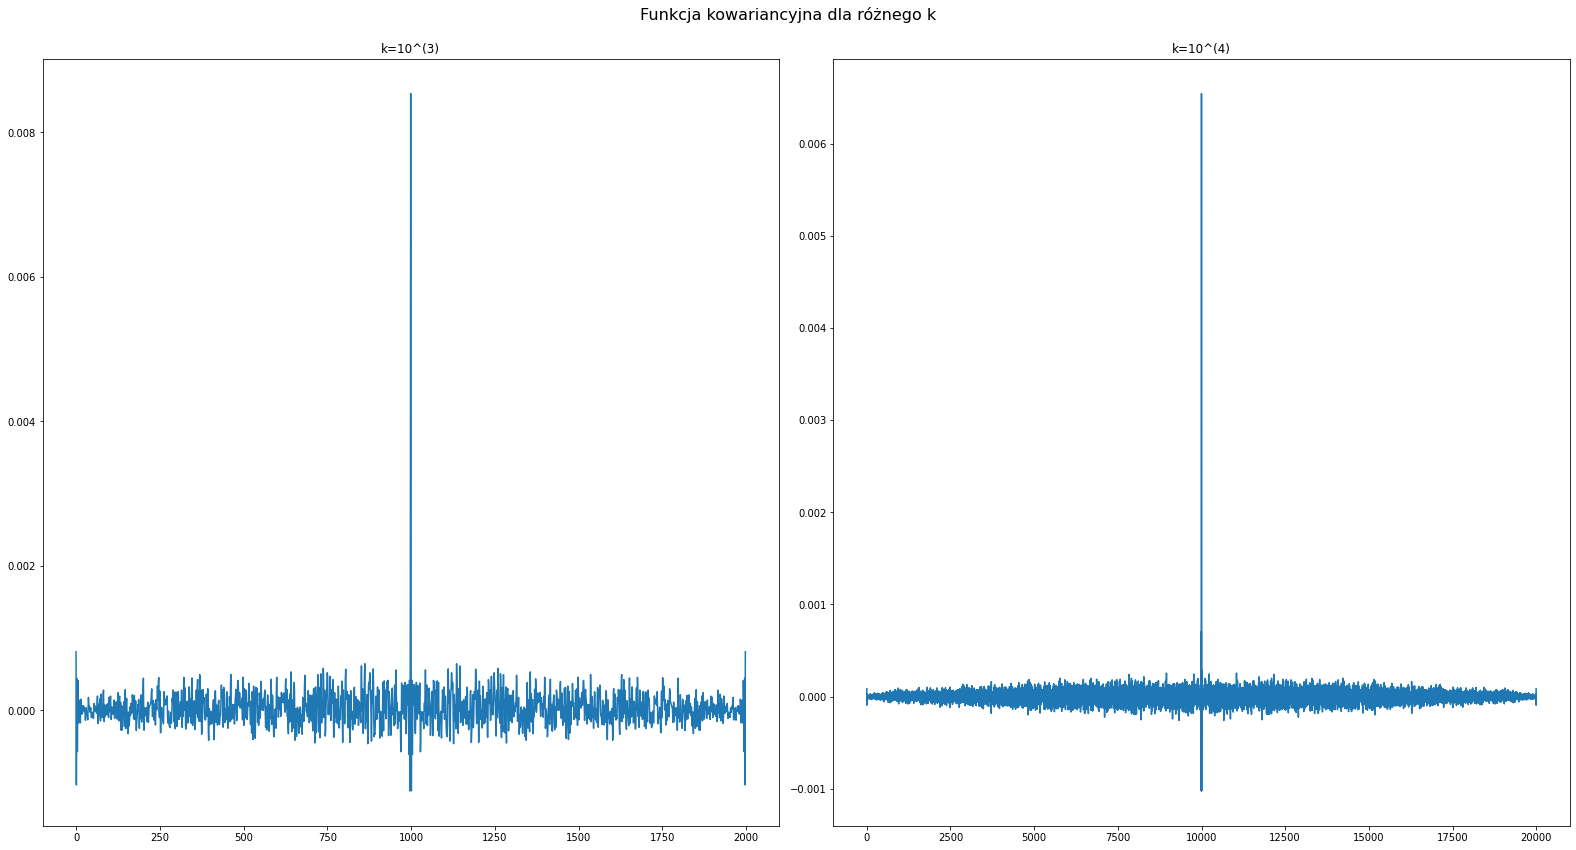

In [146]:
fig, axarr = plt.subplots(1, 2)
fig.set_figheight(12)
fig.set_figwidth(22)
fig.suptitle("Funkcja kowariancyjna dla różnego k", fontsize=16)

axarr[0].plot(covariance(noise_after_filtration_k3_fc1600, k_3))
axarr[0].set_title('k=10^(3)')
axarr[1].plot(covariance(noise_after_filtration_k4_fc1600, k_4))
axarr[1].set_title('k=10^(4)')

# Tight layout often produces nice results
# but requires the title to be spaced accordingly
fig.tight_layout()
fig.subplots_adjust(top=0.92)

plt.show()